In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import scanpy as sc
import scipy
from matplotlib import rcParams
import matplotlib.pyplot as plt
import sys
sys.path.append('../mvTCR')
import tcr_embedding.utils_training as utils

/Users/irene.bonafonte/miniforge3/envs/mvTCR/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
data = sc.read_h5ad('fig2_haniffa_lv.h5ad')

# Add HLA epitope binding information

In [ ]:
# Load IEDB databases - predicts which epitope bind which antigen (and info on the antigen species)
def disease_grouping(name):
    if type(name) != str:
        return name
    if 'SARS' in name:
        return 'SARS-CoV'
    if 'Influenza' in name:
        return 'Influenza'
    if 'herpesvirus' in name:
        return 'Human Herpesvirus'
    if 'Yellow' in name:
        return 'Yellow Fever'
    return 'Others'

iedb = pd.read_csv('IEDB.csv')
iedb = iedb.loc[(~iedb['Chain 2 CDR3 Calculated'].isna() | ~iedb['Chain 1 CDR3 Calculated'].isna()) & (~iedb.Organism.isna()),['Description','Organism']]
iedb = iedb.rename(columns={'Description': 'iedb_epitope', 'Organism': 'iedb_specie'})
iedb = iedb.drop_duplicates().set_index(f'iedb_epitope')
iedb['iedb_specie'] = iedb['iedb_specie'].apply(disease_grouping)
print(iedb.shape)
iedb['iedb_specie'].value_counts()

# Donor HLA
hla_by_donor = pd.read_csv('s3_haniffa_hla.txt', sep='\t', index_col='sample_id')
unavailable_mhcs = ['HLA-B1526']

for col in ['HLA.A', 'HLA.B', 'HLA.C']:
    hla_by_donor[f'{col}_1'] = col.replace('.', '-') + hla_by_donor[col].str.split('|').str[0]
    hla_by_donor[f'{col}_2'] = col.replace('.', '-') + hla_by_donor[col].str.split('|').str[1] 

hla_by_donor = hla_by_donor[['HLA.A_1', 'HLA.A_2', 'HLA.B_1', 'HLA.B_2', 'HLA.C_1', 'HLA.C_2']]
hla_by_donor = hla_by_donor.transpose().to_dict()
hla_by_donor = {donor: list(set([v for k, v in hla_dict.items() if v not in unavailable_mhcs])) 
                for donor, hla_dict in hla_by_donor.items()}
list(hla_by_donor.keys())[0], hla_by_donor[list(hla_by_donor.keys())[0]][0:3]

# Epitopes possibly detected by each donors repertoire
import itertools

aminos = 'ARNDCEQGHILKMFPSTWYV'
def valid_sequence(seq):
    valids = sum([let in aminos for let in seq])
    if valids==len(seq) and 1<len(seq)<16:
        return True
    else:
        return False

epitopes_by_donor = data[~data.obs['iedb_epitope'].isna() & ~data.obs['leiden_moe_cd8te'].isna()].obs[['patient_id', 'iedb_epitope']]
epitopes_by_donor['iedb_epitope'] = epitopes_by_donor['iedb_epitope'].astype(str).apply(lambda x: [el for el in list(eval(x).keys()) if valid_sequence(el)])
epitopes_by_donor = epitopes_by_donor.groupby('patient_id')['iedb_epitope'].apply(lambda x: list(set(itertools.chain.from_iterable(x)))).to_dict()

list(epitopes_by_donor.keys())[0], epitopes_by_donor[list(epitopes_by_donor.keys())[0]][0:3]

# Predict which epitopes each donor can recognize based on their HLAs
import mhcflurry
predictor = mhcflurry.Class1PresentationPredictor.load()

bound_epitopes_by_donor = {}
for donor, epitope_list in epitopes_by_donor.items():
    print(donor)
    prediction_mhc_flurry = predictor.predict(epitope_list, alleles=hla_by_donor[donor], verbose=False) # pass dicts with epitopes and hla per donor
    prediction_mhc_flurry = prediction_mhc_flurry[prediction_mhc_flurry['affinity']<500]
    bound_epitopes_by_donor[donor] = prediction_mhc_flurry['peptide'].values   

data.uns['bound_epitopes_by_donor_cd8te_cells'] = bound_epitopes_by_donor

# Pathogen each clone recognizes
cells = data.obs.loc[~data.obs['iedb_epitope'].isna() & ~data.obs['leiden_moe_cd8te'].isna()].index
data.obs['iedb_specie_filtered'] = pd.Series(dtype='object')

for cell in cells:
    epitopes = eval(data.obs.loc[cell,'iedb_epitope'])
    diseases = [iedb.loc[ep]['iedb_specie'] for ep in epitopes if ep in bound_epitopes_by_donor[data.obs.loc[cell,'patient_id']] and ep in iedb.index]
    data.obs['iedb_specie_filtered'][cell] = {}
    for d in diseases:
        if d not in data.obs['iedb_specie_filtered'][cell]:
            data.obs['iedb_specie_filtered'][cell][d] = 0
        data.obs['iedb_specie_filtered'][cell][d] += 1
        
#data.obs['iedb_specie_filtered'].value_counts()

In [ ]:
# as str
data.obs['iedb_specie_filtered'] = data.obs['iedb_specie_filtered'].astype(str)
data.obs['iedb_specie_filtered'][data.obs['iedb_specie_filtered'] == 'nan'] = np.nan
data.obs['iedb_specie_filtered'][data.obs['iedb_specie_filtered'] == '{}'] = np.nan
data.write_h5ad('fig2_haniffa_lv.h5ad')

# Define clusters

In [5]:
# cd8te cells -> moe cluster (leiden_moe_cd8te) -> select ifn+ clusters (ifnpos_leiden_moe_cd8te) -> aggregate clusters by specificity (specificity_ifnpos_leiden_moe_cd8te)
# cd8te cells -> rna cluster high res (highres_leiden_rna_cd8te) -> select ifn+ clusters (ifnpos_highres_leiden_rna_cd8te) -> aggregate clusters by specificity (specificity_ifnpos_highres_leiden_rna_cd8te)
# cd8te cells -> rna cluster low res (lowres_leiden_rna_cd8te) -> select ifn+ clusters (ifnpos_lowres_leiden_rna_cd8te) -> aggregate clusters by specificity (specificity_ifnpos_lowres_leiden_rna_cd8te)
# ifn+ cd8te cells -> aggregate by specificity (specificity_ifnpos_cd8te)

## MOE clusters

In [6]:
# CD8TE Cells, MOE clustering, IFN+ clusters, grouped by Covid specificity (covid specific, bystander vs unknown specificity clusters)
data.obs['specificity_ifnpos_leiden_moe_cd8te'] = np.nan
data.obs.loc[data.obs['leiden_moe_cd8te'].isin(['3', '6', '12', '17', '22', '51']),'specificity_ifnpos_leiden_moe_cd8te'] = 'Covid'
data.obs.loc[data.obs['leiden_moe_cd8te'].isin(['5', '16',  '45']),'specificity_ifnpos_leiden_moe_cd8te'] = 'Other'
# data.obs.loc[data.obs['leiden_moe_cd8te'].isin(['14', '25', '30', '33', '37', '38']),'specificity_ifnpos_leiden_moe_cd8te'] = 'Rest'
data.obs.specificity_ifnpos_leiden_moe_cd8te.value_counts()

Covid    3615
Other    1518
Name: specificity_ifnpos_leiden_moe_cd8te, dtype: int64

In [7]:
# CD8TE Cells, MOE clustering, IFN+ clusters
ifn_clusters = ['3', '6', '12', '17', '22', '51'] + ['5', '16',  '45'] + ['14', '25', '30', '33', '37', '38']
data.obs['ifnpos_leiden_moe_cd8te'] = np.nan
data.obs.loc[data.obs.leiden_moe_cd8te.isin(ifn_clusters),'ifnpos_leiden_moe_cd8te'] = data.obs.loc[data.obs.leiden_moe_cd8te.isin(ifn_clusters),'leiden_moe_cd8te']
data.obs.ifnpos_leiden_moe_cd8te.value_counts()

3     1067
5      997
6      989
12     694
14     653
16     459
17     444
22     398
25     308
30     193
33     141
37     105
38     101
45      62
51      23
Name: ifnpos_leiden_moe_cd8te, dtype: int64

## RNA & Specificity clusters

In [8]:
# CD8.TE and IFN+ cells, grouped by Covid specificity
data.obs['specificity_ifnpos_cd8te'] = np.nan
data.obs['ifn_high'] = '0'
data.obs.loc[data.obs['ifn response_score'] >= 0.2,'ifn_high'] = '1'
data.obs.loc[(data.obs['full_clustering']=='CD8.TE') & (data.obs['ifn_high']=='1') & (~data.obs['iedb_specie_filtered'].isna()), 'specificity_ifnpos_cd8te'] = 'Other'
data.obs.loc[data.obs.iedb_specie_filtered.str.contains('SARS',na=False) & ~data.obs['specificity_ifnpos_cd8te'].isna(),'specificity_ifnpos_cd8te'] = 'Covid'
data.obs.specificity_ifnpos_cd8te.value_counts()

Covid    1113
Other     522
Name: specificity_ifnpos_cd8te, dtype: int64

## RNA clusters

In [9]:
import torch
def load_model(adata, path_model, base_path=None):
    model_file = torch.load(path_model, map_location=torch.device('cpu'))

    params_architecture = model_file['params_architecture']
    balanced_sampling = model_file['balanced_sampling']
    metadata = model_file['metadata']
    conditional = model_file['conditional']
    optimization_mode_params = model_file['optimization_mode_params']
    label_key = model_file['label_key']

    model_class = utils.select_model_by_name(model_file['model_type'])
    model = model_class(adata, params_architecture, balanced_sampling, metadata, conditional,
                        optimization_mode_params, label_key)
    model.load(path_model, map_location=torch.device('cpu'))
    return model


# Load RNA embeddings
metadata = ['full_clustering', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 
            'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'Worst_Clinical_Status', 'Outcome', 'patient_id']

rna_model = load_model(data, '../mvTCR/saved_models/Haniffa/haniffa_tcr_rna_1.pt')
latent_rna = rna_model.get_latent(data, metadata=metadata)
latent_rna_cd8ef = latent_rna[latent_rna.obs['full_clustering']=='CD8.TE']

# Neighbours graph
sc.pp.neighbors(latent_rna_cd8ef)

No handles with labels found to put in legend.


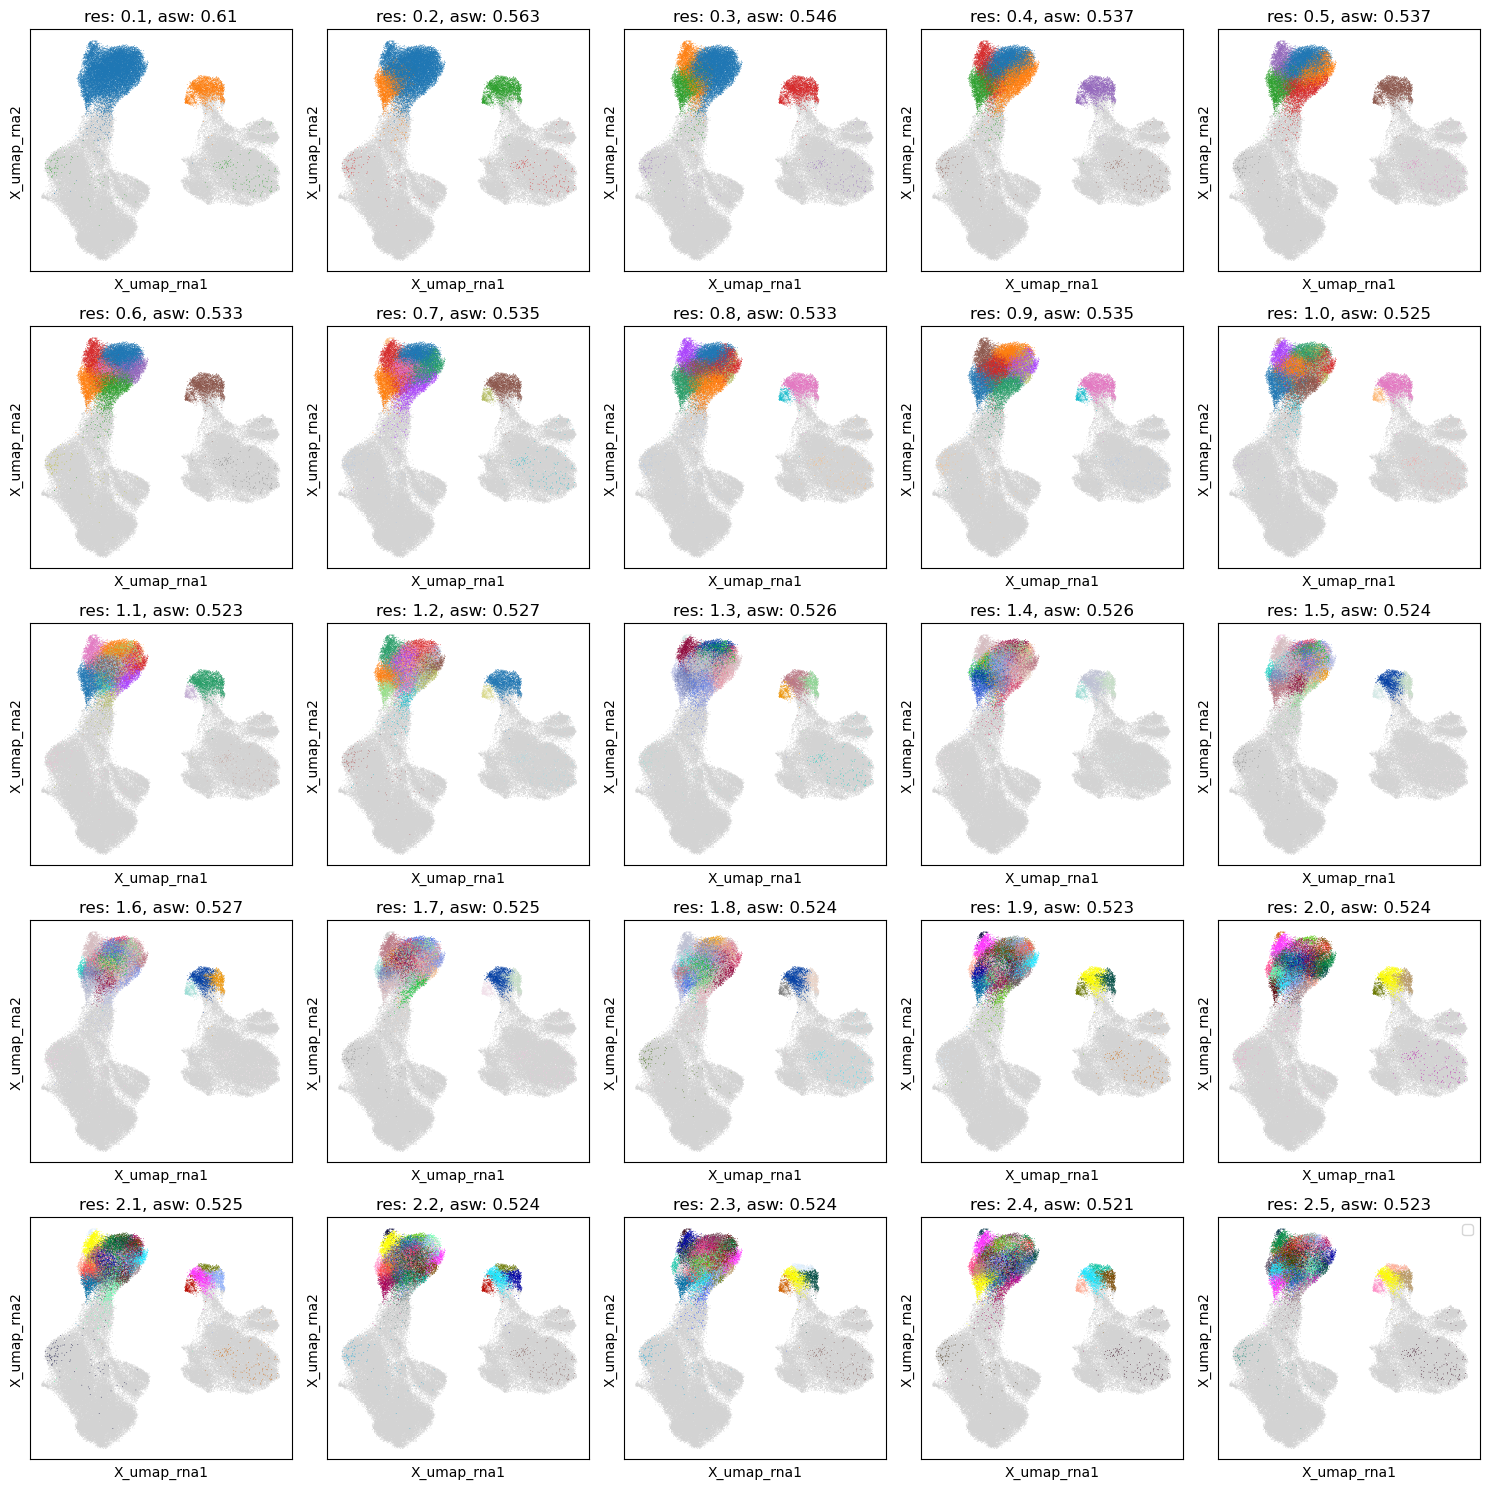

In [10]:
from sklearn.metrics.cluster import silhouette_score

n_cols = 5
n_rows = 5
fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(n_rows*3, n_cols*3))
axes = axes.reshape(-1)

# clean previous clusters
# latent_rna_cd8ef.obs = latent_rna_cd8ef.obs.loc[:, ~latent_rna_cd8ef.obs.columns.str.contains('leiden_rna_')]


# Cluster at different resolutions
for res in range(1, 26, 1):
    # Variable nmae
    label = 'leiden_rna_r'+str(round(res/10, ndigits=1))

    # Cluster
    if label not in data.obs.columns:
        sc.tl.leiden(latent_rna_cd8ef, resolution=res/10)
        latent_rna_cd8ef.obs = latent_rna_cd8ef.obs.rename(columns={'leiden': label})
        data.obs[label] = np.nan
        data.obs.loc[latent_rna_cd8ef.obs[label].index,label] = latent_rna_cd8ef.obs[label]
    
    # Compute silouhete
    asw = silhouette_score(
        X=latent_rna_cd8ef.X, labels=latent_rna_cd8ef.obs[label], metric="euclidean"
    )    
    asw = (asw + 1) / 2 # scale
    
    # Plot
    sc.pl.embedding(data, basis='X_umap_rna', color=[label], ax=axes[res-1], show=False, legend_loc=None)
    axes[res-1].set_title(f'res: {str(round(res/10, ndigits=1))}, asw: {str(round(asw, ndigits=3))}')

# Print plot
fig.tight_layout()
plt.legend()
plt.show()

In [11]:
#  3.5 yields a similar number of clusters than the MOE model
sc.tl.leiden(latent_rna_cd8ef, resolution=3.5)
len(data.obs['leiden_moe_cd8te'].value_counts()), len(latent_rna_cd8ef.obs.leiden.value_counts())

(54, 55)

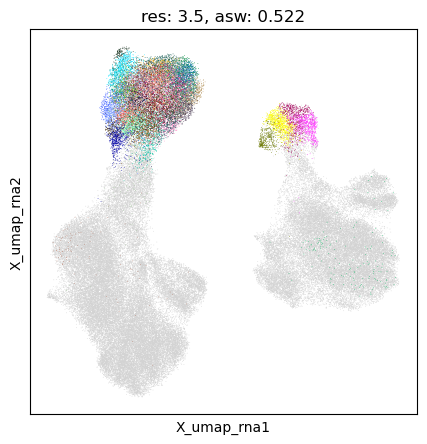

In [12]:
rcParams['figure.figsize'] = (5, 5)

res = 35
# Variable name
label = 'leiden_rna_r'+str(round(res/10, ndigits=1))

# Cluster
if label not in data.obs.columns:
    sc.tl.leiden(latent_rna_cd8ef, resolution=res/10)
    latent_rna_cd8ef.obs = latent_rna_cd8ef.obs.rename(columns={'leiden': label})
    data.obs[label] = np.nan
    data.obs.loc[latent_rna_cd8ef.obs[label].index,label] = latent_rna_cd8ef.obs[label]

# Compute silouhete
asw = silhouette_score(
    X=latent_rna_cd8ef.X, labels=latent_rna_cd8ef.obs[label], metric="euclidean"
)    
asw = (asw + 1) / 2 # scale


# Plot
sc.pl.embedding(data, basis='X_umap_rna', color=[label], show=True, legend_loc=None, title=f'res: {str(round(res/10, ndigits=1))}, asw: {str(round(asw, ndigits=3))}')

In [13]:
data.obs['highres_leiden_rna_cd8te'] = data.obs['leiden_rna_r3.5']
data.obs['lowres_leiden_rna_cd8te'] = data.obs['leiden_rna_r2.1']

In [14]:
len(data.obs['highres_leiden_rna_cd8te'].value_counts()), len(data.obs['lowres_leiden_rna_cd8te'].value_counts())

(55, 33)

### IFN levels

       35
***    19
**      1
Name: sign, dtype: int64
       21
***    11
*       1
Name: sign, dtype: int64


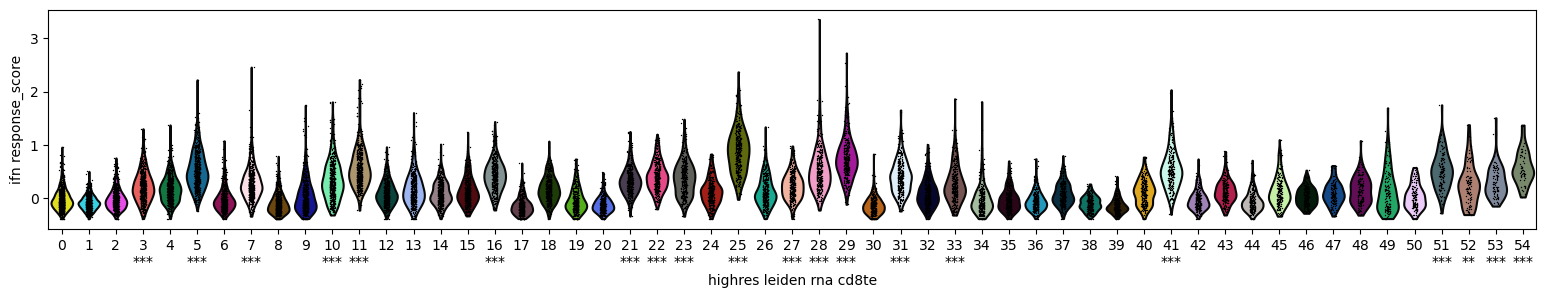

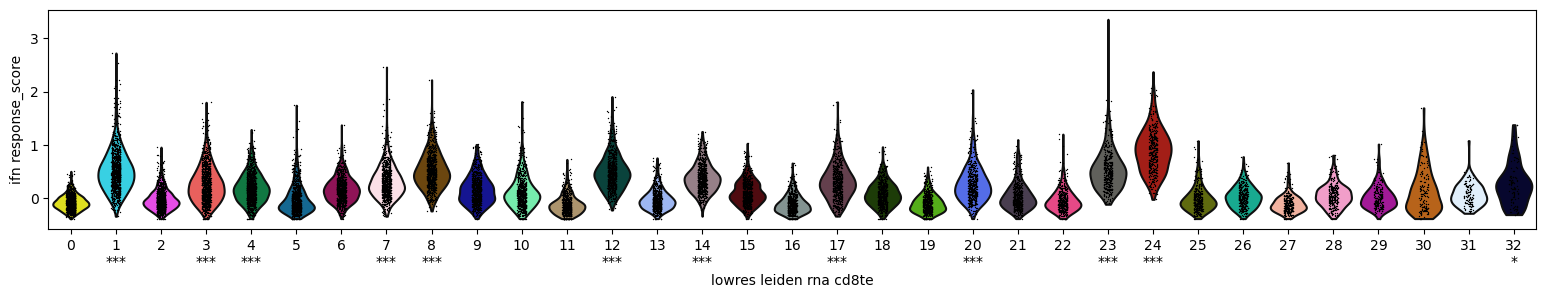

In [15]:
score = 'ifn response_score'

def map_pvalue_sign(p):
    if p < 0.001:
        return '***'
    if p < 0.01:
        return '**'
    if p < 0.05:
        return '*'
    return ''

for res in ['highres', 'lowres']:
    ps_by_cluster = {}
    ts_by_cluster = {}
    
    label = res+'_leiden_rna_cd8te'
    clusters = data.obs[label].unique()
    clusters = sorted(clusters[~clusters.isna()].astype(int))
    
    for cluster in clusters:
        cluster = str(cluster)
        ifn_cluster = data[data.obs[label]==cluster].obs[score]
        ifn_rest = data[(data.obs[label]!=cluster) & (~data.obs[label].isna())].obs[score]

        p_value = scipy.stats.ttest_ind(a=ifn_cluster, b=ifn_rest, equal_var=False, alternative='greater')

        ps_by_cluster[cluster] = p_value[1]
        ts_by_cluster[cluster] = p_value[0]

    ps_by_cluster = pd.DataFrame(data={'p_value': ps_by_cluster.values()}, 
                                 index=ps_by_cluster.keys(),)
    ps_by_cluster.index.name = 'cluster'

    ps_by_cluster['sign'] = ps_by_cluster['p_value'].map(map_pvalue_sign)
    ps_by_cluster['cluster+sign'] = ps_by_cluster.index + '\n' + ps_by_cluster['sign']
    print(ps_by_cluster['sign'].value_counts())

    rcParams['figure.figsize'] = (15, 3)
    plot = sc.pl.violin(data[~data.obs[label].isna()], keys=score, groupby=label, figsize=(20, 3), show=False)
    plot.set_xticklabels(ps_by_cluster['cluster+sign'].values)
    
    data.obs['ifnpos_'+res+'_leiden_rna_cd8te'] = np.nan
    reactive_cells = data.obs[label].isin(ps_by_cluster[ps_by_cluster['sign']=='***'].index)
    data.obs.loc[reactive_cells,'ifnpos_'+res+'_leiden_rna_cd8te'] = data.obs.loc[reactive_cells,label]


### Specificity

In [17]:
def count_plots_disease(disease_counts, cl_name):
    rcParams['figure.figsize'] = (7, 2)
    colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']
    
    # Normalize to known specificity total
    disease_counts_norm = disease_counts.copy()
    disease_counts_norm = disease_counts_norm.div(disease_counts_norm.sum(axis=1), axis=0)
    
    # Normalize including unknown specificity total
    disease_counts_ct = disease_counts.copy()
    disease_counts_ct['No Match'] = data[data.obs[cl_name].isin(disease_counts.index.values) & data.obs.iedb_specie_filtered.isna()].obs[cl_name].value_counts()[disease_counts.index].values
    disease_counts_ct = disease_counts_ct.div(disease_counts_ct.sum(axis=1), axis=0)
    
    # Classify as covid or bystander clusters
    covid_cl = disease_counts_norm[(disease_counts_norm['SARS-CoV']>0.5) & (disease_counts_ct['SARS-CoV']>0.1)].index.values
    bystander_cl = disease_counts_norm[(disease_counts_norm[['Influenza', 'Human Herpesvirus', 'Yellow Fever', 'Others']].sum(axis=1)>0.5)
            & (disease_counts_ct[['Influenza', 'Human Herpesvirus', 'Yellow Fever', 'Others']].sum(axis=1)>0.1)].index.values
    
    plots = [disease_counts.plot(kind='bar', stacked=True, edgecolor='white', color=colors),
             disease_counts_norm.plot(kind='bar', stacked=True, edgecolor='white', color=colors),
             disease_counts_ct.plot(kind='bar', stacked=True, edgecolor='white', color=colors+['#D8D8D8'])]
    
    for plot in plots:
        for tick in plot.get_xticklabels():
            if tick.get_text() in covid_cl:
                tick.set_color('#1b9e77')
                tick.set_weight('bold')

            elif tick.get_text() in bystander_cl:
                tick.set_weight('bold')
        plot.legend(bbox_to_anchor =(0.65, 1.))    
    plt.show()

    return covid_cl, bystander_cl

highres


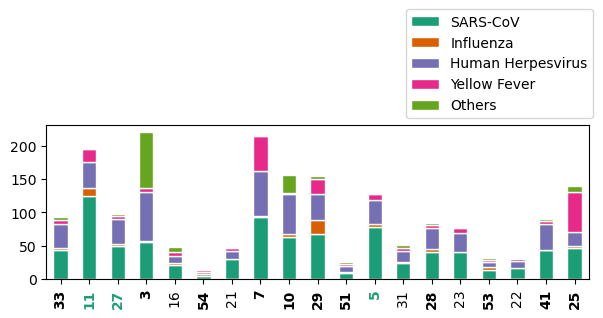

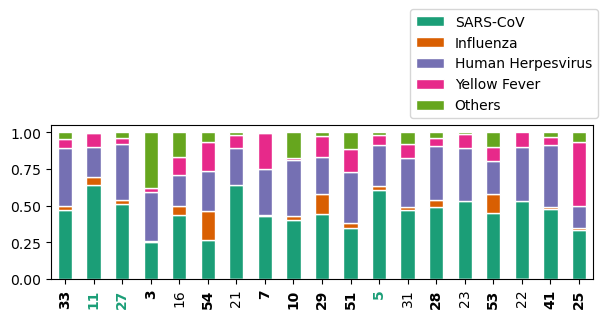

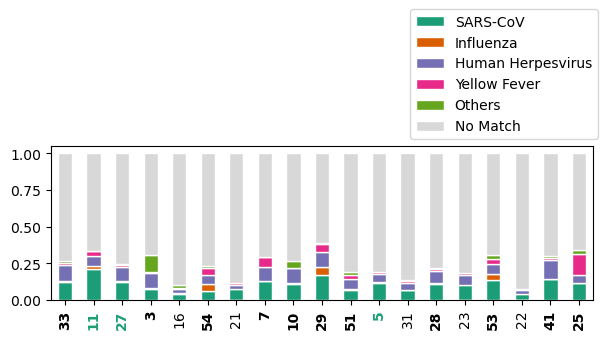

lowres


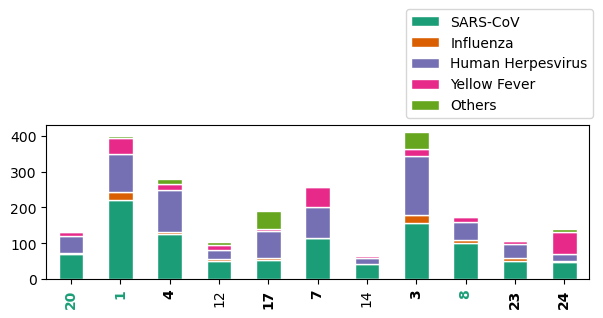

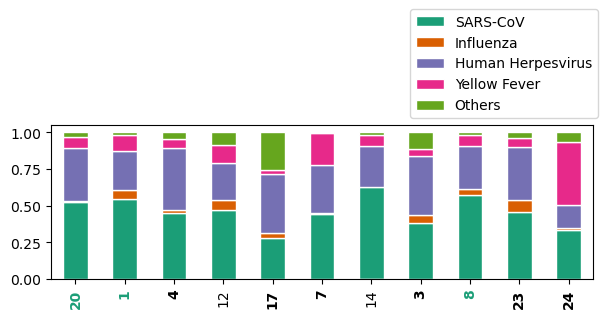

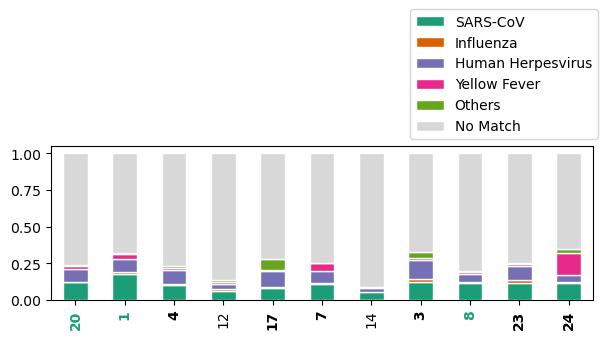

In [18]:
for res in ['highres', 'lowres']:
    print(res)
    cl_name = 'ifnpos_'+res+'_leiden_rna_cd8te'
    # specificity_cl_name = 'specificity_' + cl_name
    
    # Number of cells potentially reacting to each disease per ifn+ cluster
    react_clusters = data.obs[cl_name].unique()[1:]
    disease_by_cluster = {cl: {} for cl in react_clusters}
    for cell in data.obs[~data.obs[cl_name].isna() & ~data.obs['iedb_specie_filtered'].isna()].index:
        cl = data.obs[cl_name][cell]
        diseases = eval(data.obs['iedb_specie_filtered'][cell])

        for d in diseases:
            if d not in disease_by_cluster[cl]:
                disease_by_cluster[cl][d] = 0
            disease_by_cluster[cl][d] += 1
            
    disease_by_cluster = pd.DataFrame(disease_by_cluster).transpose().fillna(0)[['SARS-CoV','Influenza','Human Herpesvirus','Yellow Fever','Others']]
    
    # calculate proportions of disease recognition by cluster, classifyt as covid or bystander cluster and plot
    covid_cl, bystander_cl = count_plots_disease(disease_by_cluster, cl_name)
    
    data.obs['specificity_'+cl_name] = np.nan
    data.obs.loc[data.obs[cl_name].isin(covid_cl),'specificity_'+cl_name] = 'Covid'
    data.obs.loc[data.obs[cl_name].isin(bystander_cl),'specificity_'+cl_name] = 'Other'    

## Selection

cd8te cells $\rightarrow$ moe cluster (`leiden_moe_cd8te`) $\rightarrow$ select ifn+ clusters (`ifnpos_leiden_moe_cd8te`) $\rightarrow$ aggregate clusters by specificity (`specificity_ifnpos_leiden_moe_cd8te`)

cd8te cells $\rightarrow$ rna cluster high res (`highres_leiden_rna_cd8te`) $\rightarrow$ select ifn+ clusters (`ifnpos_highres_leiden_rna_cd8te`) $\rightarrow$ aggregate clusters by specificity (`specificity_ifnpos_highres_leiden_rna_cd8te`)

cd8te cells $\rightarrow$ rna cluster low res (`lowres_leiden_rna_cd8te`) $\rightarrow$ select ifn+ clusters (`ifnpos_lowres_leiden_rna_cd8te`) $\rightarrow$ aggregate clusters by specificity (`specificity_ifnpos_lowres_leiden_rna_cd8te`)

ifn+ cd8te cells $\rightarrow$ aggregate by specificity (`specificity_ifnpos_cd8te`)

## Clusters plots

### UMAPs

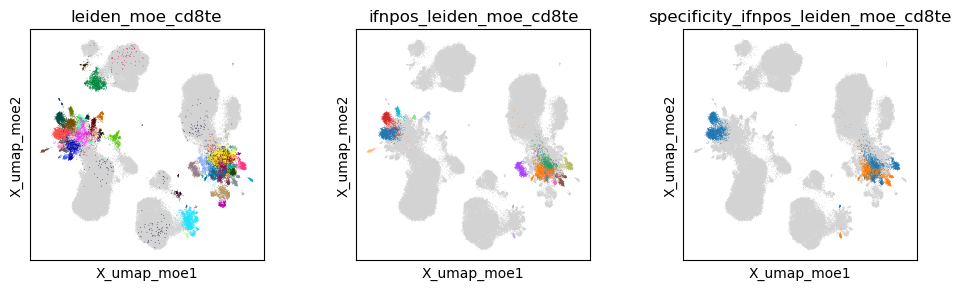

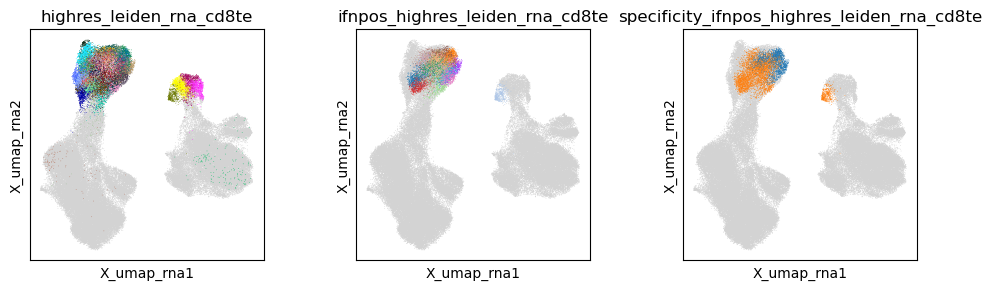

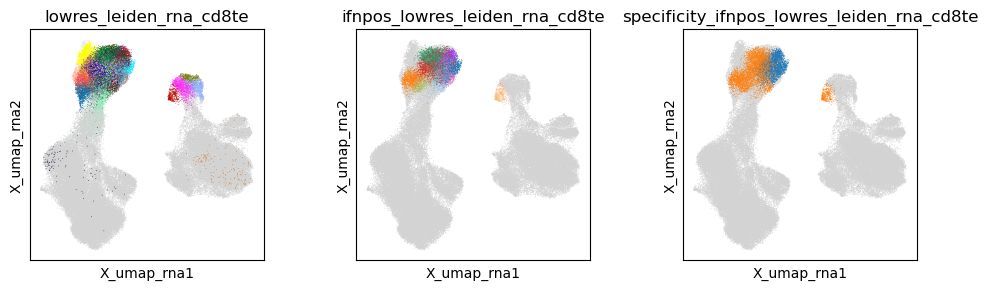

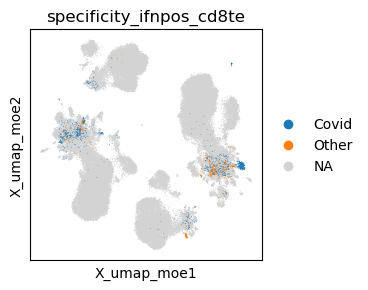

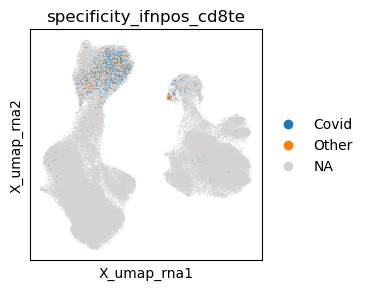

In [19]:
rcParams['figure.figsize'] = (3, 3)
sc.pl.embedding(data, basis='X_umap_moe', color=['leiden_moe_cd8te','ifnpos_leiden_moe_cd8te','specificity_ifnpos_leiden_moe_cd8te'], ncols=3, legend_loc=None)
sc.pl.embedding(data, basis='X_umap_rna', color=['highres_leiden_rna_cd8te','ifnpos_highres_leiden_rna_cd8te','specificity_ifnpos_highres_leiden_rna_cd8te'], ncols=3, legend_loc=None)
sc.pl.embedding(data, basis='X_umap_rna', color=['lowres_leiden_rna_cd8te','ifnpos_lowres_leiden_rna_cd8te','specificity_ifnpos_lowres_leiden_rna_cd8te'], ncols=3, legend_loc=None)
sc.pl.embedding(data, basis='X_umap_moe', color=['specificity_ifnpos_cd8te'], ncols=3)
sc.pl.embedding(data, basis='X_umap_rna', color=['specificity_ifnpos_cd8te'], ncols=3)

### Diff Exp genes

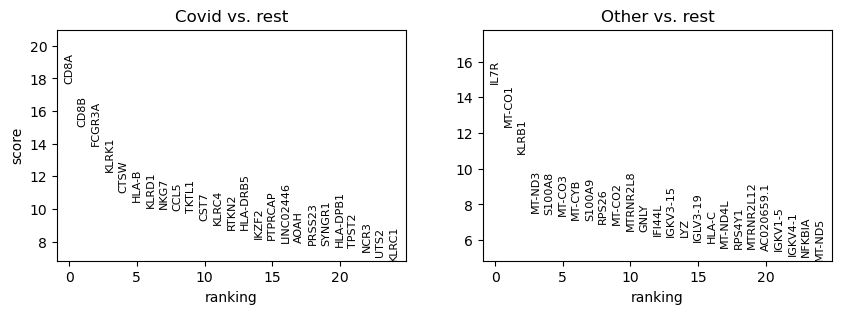

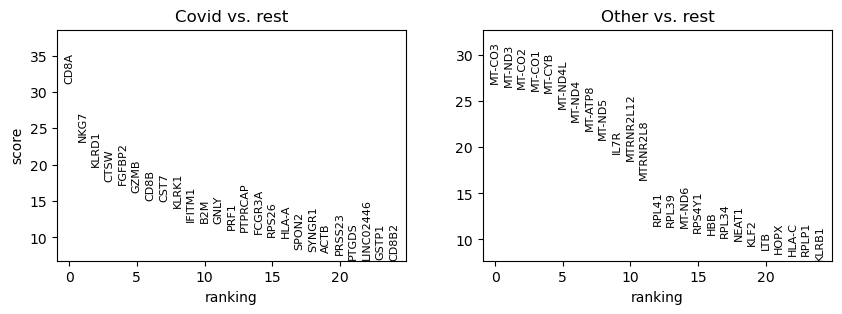

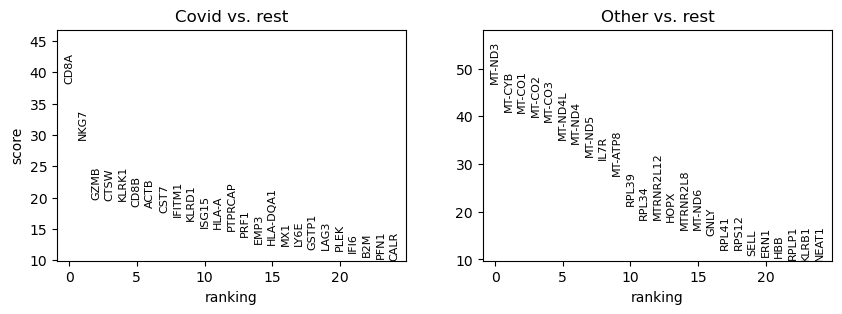

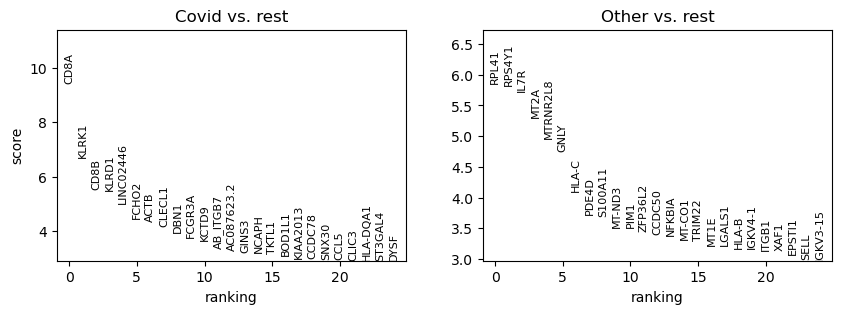

In [20]:
rcParams['figure.figsize'] = (5, 3)

filter_gene_prefixs = ['TRAV', 'TRAJ', 'TRAC', 'TRB', 'TRDV', 'TRDC', 'TRG']
non_tcr_genes = data.var_names
for prefix in filter_gene_prefixs:
    non_tcr_genes = [el for el in non_tcr_genes if not el.startswith(prefix)]

deg = {}
for cl in ['specificity_ifnpos_leiden_moe_cd8te','specificity_ifnpos_highres_leiden_rna_cd8te','specificity_ifnpos_lowres_leiden_rna_cd8te','specificity_ifnpos_cd8te']:
    test_data = data[~data.obs[cl].isna(),non_tcr_genes]
    sc.tl.rank_genes_groups(test_data, cl, method='t-test')
    sc.pl.rank_genes_groups(test_data, n_genes=25, sharey=False)

    result = test_data.uns['rank_genes_groups']
    deg[cl] = pd.DataFrame({'names': result['names']['Covid'], 'pvals': result['pvals']['Covid'], 'pvals_adj': result['pvals_adj']['Covid'], 'logfoldchanges': result['logfoldchanges']['Covid']})
    deg[cl].sort_values(by='pvals_adj', inplace=True)
    deg[cl] = deg[cl][deg[cl].pvals_adj < 0.05]
    deg[cl]['direction'] = 'up'
    deg[cl].loc[deg[cl].logfoldchanges < 0, 'direction'] = 'down'


In [22]:
overlap = pd.DataFrame({
    'MOE covid': [],
    'MOE bystander': [],
    'RNA covid': [],
    'RNA bystander': [],
    'MOE covid&RNA covid': [],
    'MOE bystander&RNA bystander': [],
    'MOE covid&RNA bystander': [],
    'MOE bystander&RNA covid': []
})

deg_moe = deg['specificity_ifnpos_leiden_moe_cd8te']

for rna_cl in ['specificity_ifnpos_highres_leiden_rna_cd8te', 'specificity_ifnpos_lowres_leiden_rna_cd8te', 'specificity_ifnpos_cd8te']:
    deg_rna = deg[rna_cl]
    up_up = deg_moe.names[deg_moe.direction=='up'].isin(deg_rna.names[deg_rna.direction=='up']).sum()
    down_down = deg_moe.names[deg_moe.direction=='down'].isin(deg_rna.names[deg_rna.direction=='down']).sum()
    up_down = deg_moe.names[deg_moe.direction=='up'].isin(deg_rna.names[deg_rna.direction=='down']).sum()
    down_up = deg_moe.names[deg_moe.direction=='down'].isin(deg_rna.names[deg_rna.direction=='up']).sum()
    up_ = (~deg_moe.names[deg_moe.direction=='up'].isin(deg_rna.names)).sum()
    down_ = (~deg_moe.names[deg_moe.direction=='down'].isin(deg_rna.names)).sum()
    _up = (~deg_rna.names[deg_rna.direction=='up'].isin(deg_moe.names)).sum()
    _down = (~deg_rna.names[deg_rna.direction=='down'].isin(deg_moe.names)).sum()
    overlap.loc[rna_cl,:] = [up_, down_, _up, _down, up_up, down_down, up_down, down_up]
    
overlap.to_csv('deg_overlap.csv')
overlap

MOE covid  MOE bystander  \
specificity_ifnpos_highres_leiden_rna_cd8te       48.0           33.0   
specificity_ifnpos_lowres_leiden_rna_cd8te        41.0           19.0   
specificity_ifnpos_cd8te                          87.0           65.0   

                                             RNA covid  RNA bystander  \
specificity_ifnpos_highres_leiden_rna_cd8te       44.0          124.0   
specificity_ifnpos_lowres_leiden_rna_cd8te       104.0          135.0   
specificity_ifnpos_cd8te                           4.0            1.0   

                                             MOE covid&RNA covid  \
specificity_ifnpos_highres_leiden_rna_cd8te                 39.0   
specificity_ifnpos_lowres_leiden_rna_cd8te                  45.0   
specificity_ifnpos_cd8te                                     5.0   

                                             MOE bystander&RNA bystander  \
specificity_ifnpos_highres_leiden_rna_cd8te                         33.0   
specificity_ifnpos_lowres_leiden_rna_cd8te                          39.0   
specificity_ifnpos_cd8te                                             6.0   

                                             MOE covid&RNA bystander  \
specificity_ifnpos_highres_leiden_rna_cd8te                      5.0   
specificity_ifnpos_lowres_leiden_rna_cd8te                       6.0   
specificity_ifnpos_cd8te                                         0.0   

                                             MOE bystander&RNA covid  
specificity_ifnpos_highres_leiden_rna_cd8te                      5.0  
specificity_ifnpos_lowres_leiden_rna_cd8te                      13.0  
specificity_ifnpos_cd8te                                         0.0

### Plot of diff exp genes shown in paper

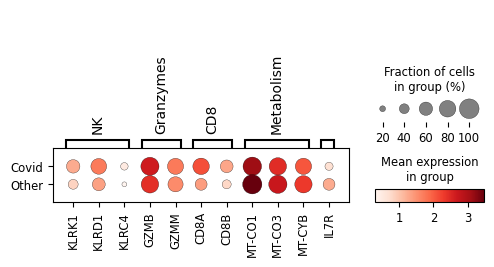

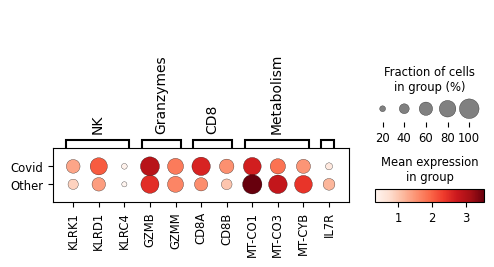

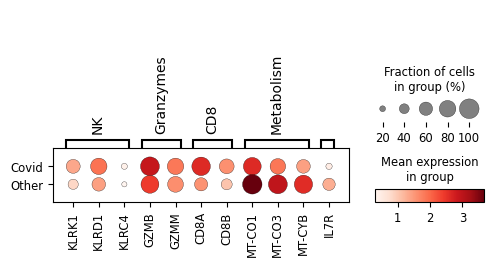

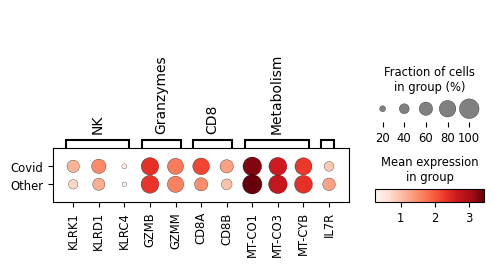

In [23]:
rcParams['figure.figsize'] = (20, 20)
marker_genes_dict = {'NK': ['KLRK1','KLRD1','KLRC4'], 'Granzymes': ['GZMB','GZMM'], 'CD8': ['CD8A','CD8B'], 'Metabolism': ['MT-CO1','MT-CO3','MT-CYB'], '': ['IL7R']}
for cl in ['specificity_ifnpos_leiden_moe_cd8te', 'specificity_ifnpos_highres_leiden_rna_cd8te', 'specificity_ifnpos_lowres_leiden_rna_cd8te', 'specificity_ifnpos_cd8te']:
    sc.pl.dotplot(data, marker_genes_dict, cl, dendrogram=False)

### all distances

In [89]:
from sklearn import metrics

In [230]:
distances = {}
categories = {}

# cell names
cellnm = data.obs.loc[data.obs.full_clustering == 'CD8.TE',:].index

# rna dist
distances['rna'] = metrics.pairwise_distances(data[cellnm].obsm['X_pca'])

# tcr dist
clonotypes = data[cellnm].obs[['v_gene_alpha', 'IR_VJ_1_junction_aa', 'v_gene_beta', 'IR_VDJ_1_junction_aa', 'clonotype']].drop_duplicates(['IR_VJ_1_junction_aa', 'IR_VDJ_1_junction_aa']).reset_index(drop=True)
clonotypes = clonotypes.rename(columns={
    'v_gene_alpha': 'v_a_gene',
    'IR_VJ_1_junction_aa': 'cdr3_a_aa',
    'v_gene_beta': 'v_b_gene',
    'IR_VDJ_1_junction_aa':  'cdr3_b_aa'
})
clonotypes[clonotypes.columns[0:4]] = clonotypes[clonotypes.columns[0:4]].astype(str)
clonotypes[['v_a_gene','v_b_gene']] = clonotypes[['v_a_gene','v_b_gene']] + '*01'

tr = TCRrep(cell_df=clonotypes, organism='human', chains=['alpha','beta'])
distances['tcr'] = tr.pw_cdr3_a_aa + tr.pw_cdr3_b_aa
distances['tcr'] = pd.DataFrame(distances['tcr'], columns=tr.clone_df['clonotype'], index=tr.clone_df['clonotype']) # pdDf to add index
clones = data[cellnm].obs['clonotype']
distances['tcr'] = distances['tcr'].loc[clones, clones].values

# ifn score dist
distances['ifn'] = metrics.pairwise_distances(data[cellnm].obs['ifn response_score'].values.reshape(-1, 1))

# days from onset dist
distances['daysfromonset'] = metrics.pairwise_distances(data[cellnm].obs['days_from_onset_numeric'].fillna(0).values.reshape(-1, 1))

In [314]:
def create_dataset(cells_cl, m=2, plot_data=True):
    
    dt = np.zeros((len(cells_cl), m))
    
    for cluster in cells_cl.unique().astype(str):
        mean = np.random.normal(loc=0, scale=5, size=m)
        sd = [[2,0],[0,2]]
        n = np.sum(cells_cl == cluster)
        dt[cells_cl == cluster, :] = np.random.multivariate_normal(mean=mean, cov= sd, size= n)
    
    dt_plot = pd.DataFrame(dt, columns=['x','y'])
    dt_plot['cluster'] = cells_cl.values

    if plot_data:
        sns.scatterplot(dt_plot, x='x', y='y', hue='cluster', s=3)
        plt.legend([],[], frameon=False)
        plt.show()

    return dt

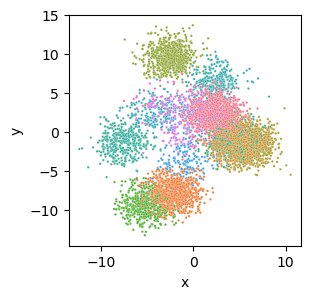

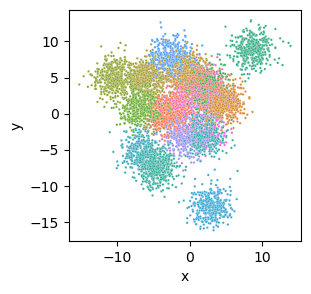

ifnpos_leiden_moe_cd8te vs ifnpos_highres_leiden_rna_cd8te mean random distance - p value: 0.118, t value: 1.6116


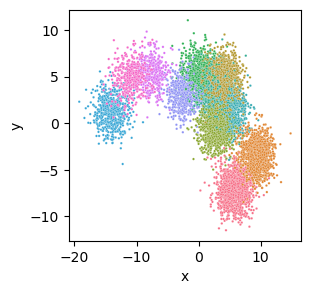

ifnpos_leiden_moe_cd8te vs ifnpos_lowres_leiden_rna_cd8te mean random distance - p value: 0.6195, t value: 0.5032


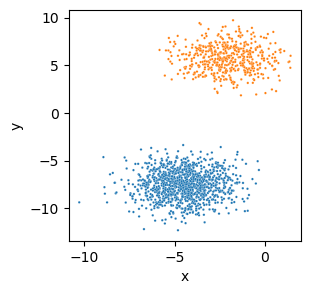

ifnpos_leiden_moe_cd8te vs specificity_ifnpos_cd8te mean random distance - p value: 0.6474, t value: 0.5212


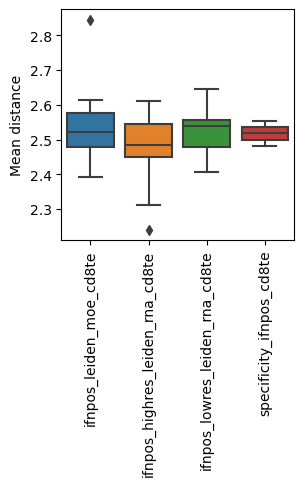

In [317]:
# just a simulation for an internal checking
pvalues = pd.DataFrame({'Clustering criteria': [], 'Cluster': [], 'P-value': [], 'T-value': [], 'Mean distance': [], 'Background mean distance': []})

for cl_name in clustering_criteria:
    cells = clusters[cl_name][~clusters[cl_name].isna()]
    
    dt = create_dataset(cells)
    distance = metrics.pairwise_distances(dt)
    
    for cluster in cells.unique().astype(str):
        mask_cluster = (cells == cluster).values
        cl_dist = distance[mask_cluster,:][:, mask_cluster].flatten()
        bg_dist = distance[mask_cluster,:][:,np.invert(mask_cluster)].flatten()
        p = scipy.stats.ttest_ind(a=cl_dist, b=bg_dist, equal_var=False, alternative='less')
        pvalues.loc[dist_space+cl_name+cluster,:] = [cl_name, cluster, p[1], p[0], np.mean(cl_dist), np.mean(bg_dist)]
        
    if cl_name != 'ifnpos_leiden_moe_cd8te':
        pval = scipy.stats.ttest_ind(a=pvalues.loc[pvalues['Clustering criteria'] ==  'ifnpos_leiden_moe_cd8te','Mean distance'], 
                              b=pvalues.loc[pvalues['Clustering criteria'] ==  cl_name,'Mean distance'], 
                              equal_var=False)
        print(f'ifnpos_leiden_moe_cd8te vs {cl_name} mean random distance - p value: {round(pval[1], 4)}, t value: {round(pval[0], 4)}')  
        
sns.boxplot(data=pvalues, x="Clustering criteria", y="Mean distance")
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel(f'Mean distance')
# plt.plot([-0.5, 3.5], [pvalues['Background mean distance'].mean(), pvalues['Background mean distance'].mean()], color='red', linestyle='dashed') 
plt.show()
    

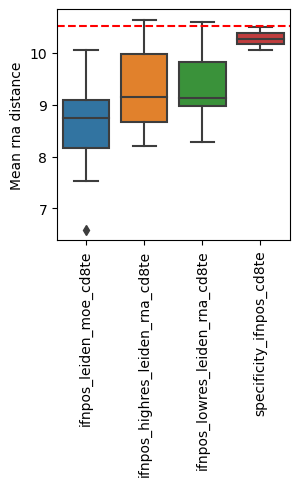

ifnpos_leiden_moe_cd8te vs ifnpos_lowres_leiden_rna_cd8te rna distance - p value: 0.0275, t value: -2.3522
ifnpos_leiden_moe_cd8te vs ifnpos_highres_leiden_rna_cd8te rna distance - p value: 0.0282, t value: -2.3115
ifnpos_leiden_moe_cd8te vs specificity_ifnpos_cd8te rna distance - p value: 0.0069, t value: -5.2497


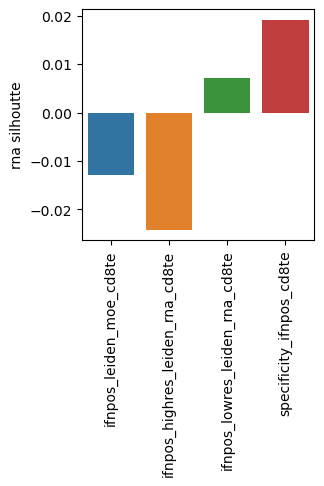

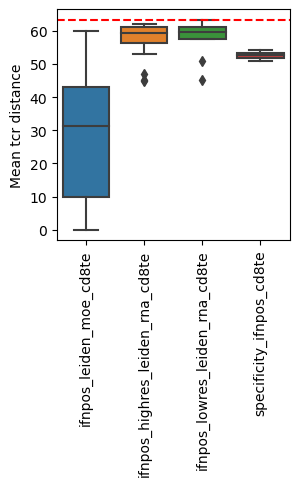

ifnpos_leiden_moe_cd8te vs ifnpos_lowres_leiden_rna_cd8te tcr distance - p value: 0.0, t value: -5.5802
ifnpos_leiden_moe_cd8te vs ifnpos_highres_leiden_rna_cd8te tcr distance - p value: 0.0, t value: -5.542
ifnpos_leiden_moe_cd8te vs specificity_ifnpos_cd8te tcr distance - p value: 0.0004, t value: -4.5956


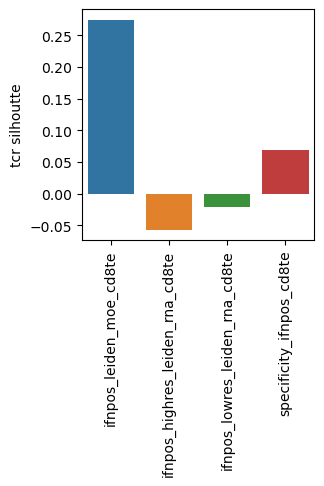

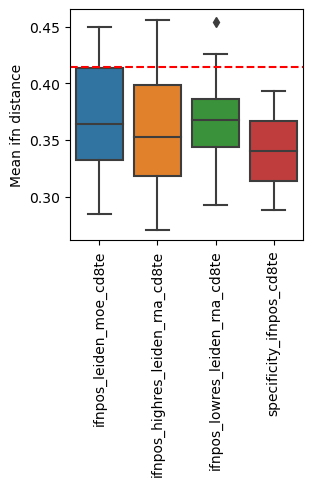

ifnpos_leiden_moe_cd8te vs ifnpos_lowres_leiden_rna_cd8te ifn distance - p value: 0.8362, t value: 0.2092
ifnpos_leiden_moe_cd8te vs ifnpos_highres_leiden_rna_cd8te ifn distance - p value: 0.4094, t value: 0.8369
ifnpos_leiden_moe_cd8te vs specificity_ifnpos_cd8te ifn distance - p value: 0.6668, t value: 0.5567


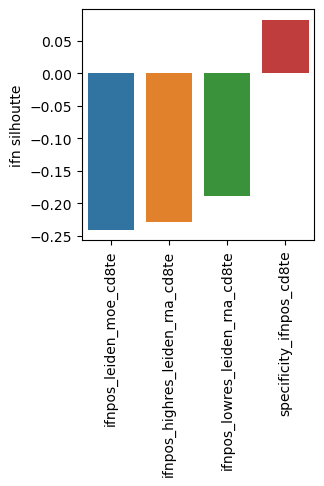

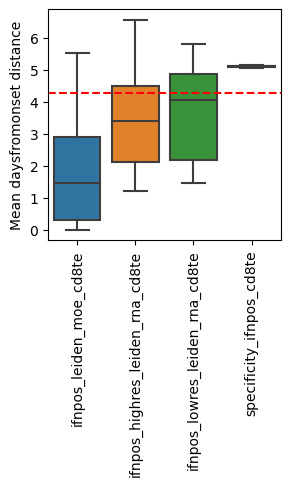

ifnpos_leiden_moe_cd8te vs ifnpos_lowres_leiden_rna_cd8te daysfromonset distance - p value: 0.0154, t value: -2.6167
ifnpos_leiden_moe_cd8te vs ifnpos_highres_leiden_rna_cd8te daysfromonset distance - p value: 0.0058, t value: -2.9812
ifnpos_leiden_moe_cd8te vs specificity_ifnpos_cd8te daysfromonset distance - p value: 0.0, t value: -7.156


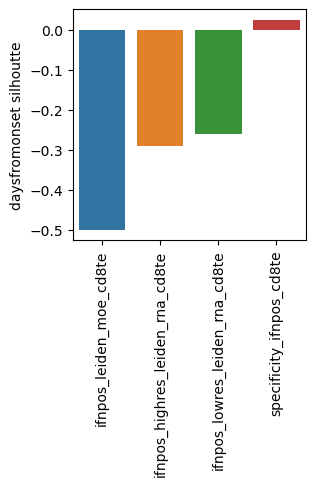

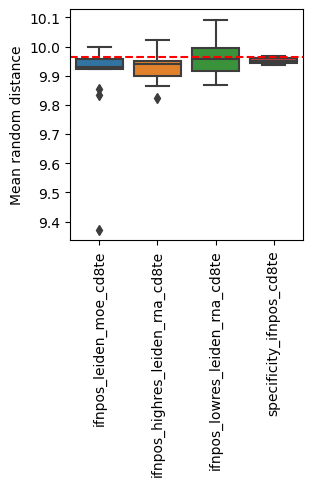

ifnpos_leiden_moe_cd8te vs ifnpos_lowres_leiden_rna_cd8te random distance - p value: 0.1436, t value: -1.5227
ifnpos_leiden_moe_cd8te vs ifnpos_highres_leiden_rna_cd8te random distance - p value: 0.4049, t value: -0.8545
ifnpos_leiden_moe_cd8te vs specificity_ifnpos_cd8te random distance - p value: 0.2061, t value: -1.3265


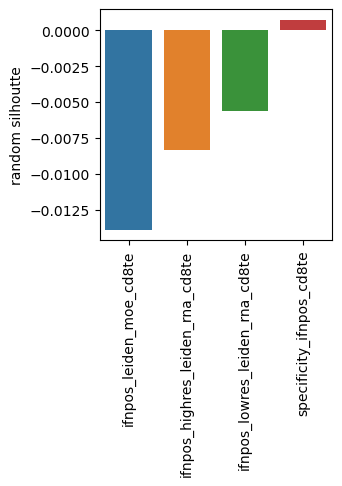

In [231]:
import seaborn as sns
rcParams['figure.figsize'] = (3, 3)

clustering_criteria = ['ifnpos_leiden_moe_cd8te','ifnpos_highres_leiden_rna_cd8te','ifnpos_lowres_leiden_rna_cd8te','specificity_ifnpos_cd8te']
clusters = data.obs.loc[cellnm,clustering_criteria]

pvalues = pd.DataFrame({'Distance space': [], 'Clustering criteria': [], 'Cluster': [], 'P-value': [], 'T-value': [], 'Mean distance': [], 'Background mean distance': []})
scores = pd.DataFrame({'Distance space': [], 'Clustering criteria': [], 'silhoutte': []})

for dist_space in distances:
    
    for cl_name in clustering_criteria:
        
        if dist_space == 'daysfromonset':
            non_na = ~data[cellnm].obs.days_from_onset_numeric.isna() & ~clusters[cl_name].isna()
            
        else:
            non_na = ~clusters[cl_name].isna().values
            
        scores.loc[dist_space+cl_name,:] = [dist_space, cl_name, metrics.silhouette_score(distances[dist_space][non_na, :][:, non_na], clusters[non_na][cl_name], metric='precomputed')]
        
        
        # Is intra cl distance higher than distance to other clusters
        react_leiden = data.obs[cl_name].unique().astype(str)[1:]
        
        for i, cluster in enumerate(react_leiden):
            mask_cluster = (clusters.loc[non_na,cl_name] == cluster).values
            d = distances[dist_space][non_na,:][:,non_na]
            cl_dist = d[mask_cluster,:][:, mask_cluster].flatten()
            bg_dist = d[mask_cluster,:][:,np.invert(mask_cluster)].flatten()
            p = scipy.stats.ttest_ind(a=cl_dist, b=bg_dist, equal_var=False, alternative='less')
            pvalues.loc[dist_space+cl_name+cluster,:] = [dist_space, cl_name, cluster, p[1], p[0], np.mean(cl_dist), np.mean(bg_dist)]
            
    # Plot mean distances
    tmp = pvalues[pvalues['Distance space']==dist_space]
    sns.boxplot(data=tmp, x="Clustering criteria", y="Mean distance")
    plt.xticks(rotation=90)
    plt.xlabel("")
    plt.ylabel(f'Mean {dist_space} distance')
    plt.plot([-0.5, 3.5], [tmp['Background mean distance'].mean(), tmp['Background mean distance'].mean()], color='red', linestyle='dashed') 
    plt.show()
    
    # Test difference in mean distance
    tmp = tmp[~pvalues['Mean distance'].isna()]
    for cl in ['ifnpos_lowres_leiden_rna_cd8te','ifnpos_highres_leiden_rna_cd8te', 'specificity_ifnpos_cd8te']:

        pval = scipy.stats.ttest_ind(a=tmp.loc[tmp['Clustering criteria'] ==  'ifnpos_leiden_moe_cd8te','Mean distance'], 
                              b=tmp.loc[tmp['Clustering criteria'] ==  cl,'Mean distance'], 
                              equal_var=False)

        print(f'ifnpos_leiden_moe_cd8te vs {cl} {dist_space} distance - p value: {round(pval[1], 4)}, t value: {round(pval[0], 4)}')
    
    
    # Plot silouhette
    tmp = scores[scores['Distance space']==dist_space]
    sns.barplot(data=tmp, x="Clustering criteria", y="silhoutte")
    plt.xticks(rotation=90)    
    plt.xlabel("")
    plt.ylabel(f'{dist_space} silhoutte')
    plt.show()

ifnpos_leiden_moe_cd8te vs ifnpos_highres_leiden_rna_cd8te variance - p value: 0.0239, t value: -2.3804
ifnpos_leiden_moe_cd8te vs ifnpos_lowres_leiden_rna_cd8te variance - p value: 0.057, t value: -2.0099
ifnpos_leiden_moe_cd8te vs specificity_ifnpos_cd8te variance - p value: 0.0, t value: -7.7127


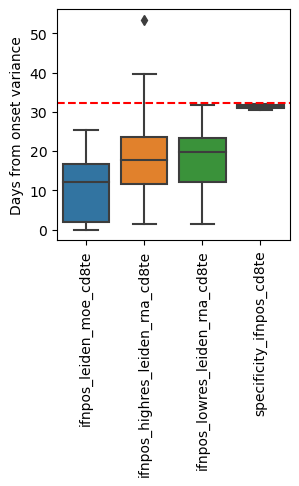

In [224]:
rcParams['figure.figsize'] = (3, 3)

dt = data.obs.loc[cellnm,clustering_criteria+['days_from_onset_numeric']]
non_na = ~dt['days_from_onset_numeric'].isna() & ~dt[cl_name].isna()
scores = pd.DataFrame({'Clustering criteria': [], 'Cluster': [], 'Variance': []})

for cl_name in clustering_criteria:
    var = dt[non_na].groupby(cl_name)['days_from_onset_numeric'].var()
    var = var[~var.isna()].reset_index().rename(columns={cl_name: 'Cluster', 'days_from_onset_numeric': 'Variance'})
    var['Clustering criteria'] = cl_name
    scores = scores.append(var)
    
    if cl_name != 'ifnpos_leiden_moe_cd8te':
        pval = scipy.stats.ttest_ind(a=scores.loc[scores['Clustering criteria'] ==  'ifnpos_leiden_moe_cd8te','Variance'], 
                              b=scores.loc[scores['Clustering criteria'] ==  cl_name,'Variance'], 
                              equal_var=False)
        print(f'ifnpos_leiden_moe_cd8te vs {cl_name} variance - p value: {round(pval[1], 4)}, t value: {round(pval[0], 4)}')        
    
# Plot variance
bckg =dt[non_na].var()[0]
sns.boxplot(data=scores, x="Clustering criteria", y="Variance")
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel(f'Days from onset variance')
plt.plot([-0.5, 3.5], [bckg, bckg], color='red', linestyle='dashed') 
plt.show()


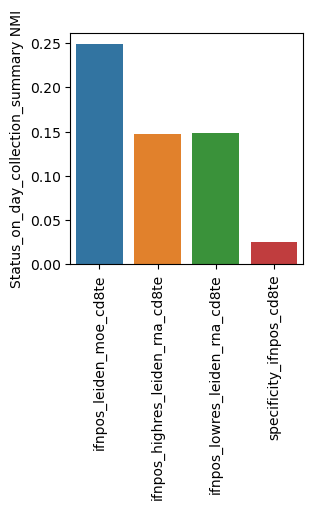

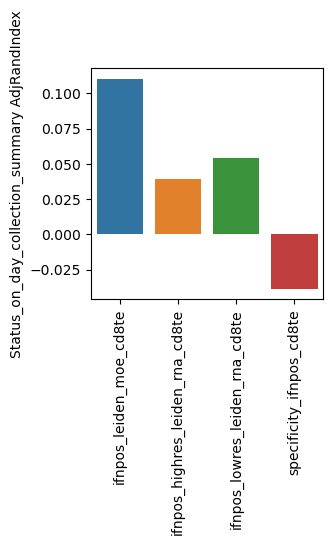

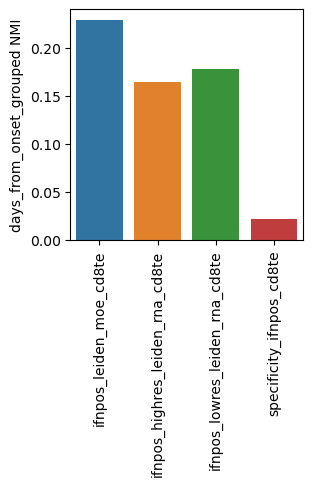

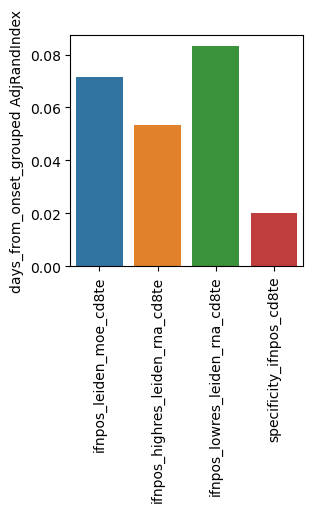

In [178]:
rcParams['figure.figsize'] = (3, 3)

categories = ['Status_on_day_collection_summary','days_from_onset_grouped']
dt = data.obs.loc[cellnm,clustering_criteria+categories]
scores = pd.DataFrame({'Label': [], 'Clustering criteria': [], 'NMI': [], 'AdjRandIndex': []})

for label in categories:
    
    for cl_name in clustering_criteria:
        
        non_na = ~dt[label].isna() & ~dt[cl_name].isna()
            
        nmi = metrics.normalized_mutual_info_score(dt.loc[non_na, label], dt.loc[non_na, cl_name])
        rand = metrics.adjusted_rand_score(dt.loc[non_na, label], dt.loc[non_na, cl_name])
        
        scores.loc[dist_space+cl_name,:] = [label, cl_name, nmi, rand]
    
    # Plot silouhette
    for metric in ['NMI', 'AdjRandIndex']:
        tmp = scores[scores['Label']==label]
        sns.barplot(data=tmp, x="Clustering criteria", y=metric)
        plt.xticks(rotation=90)    
        plt.xlabel("")
        plt.ylabel(f'{label} {metric}')
        plt.show()

### RNA distance

In [ ]:
# cd8te cells -> moe cluster (leiden_moe_cd8te) -> select ifn+ clusters (ifnpos_leiden_moe_cd8te) -> aggregate clusters by specificity (specificity_ifnpos_leiden_moe_cd8te)
# cd8te cells -> rna cluster high res (highres_leiden_rna_cd8te) -> select ifn+ clusters (ifnpos_highres_leiden_rna_cd8te) -> aggregate clusters by specificity (specificity_ifnpos_highres_leiden_rna_cd8te)
# cd8te cells -> rna cluster low res (lowres_leiden_rna_cd8te) -> select ifn+ clusters (ifnpos_lowres_leiden_rna_cd8te) -> aggregate clusters by specificity (specificity_ifnpos_lowres_leiden_rna_cd8te)
# ifn+ cd8te cells -> aggregate by specificity (specificity_ifnpos_cd8te)

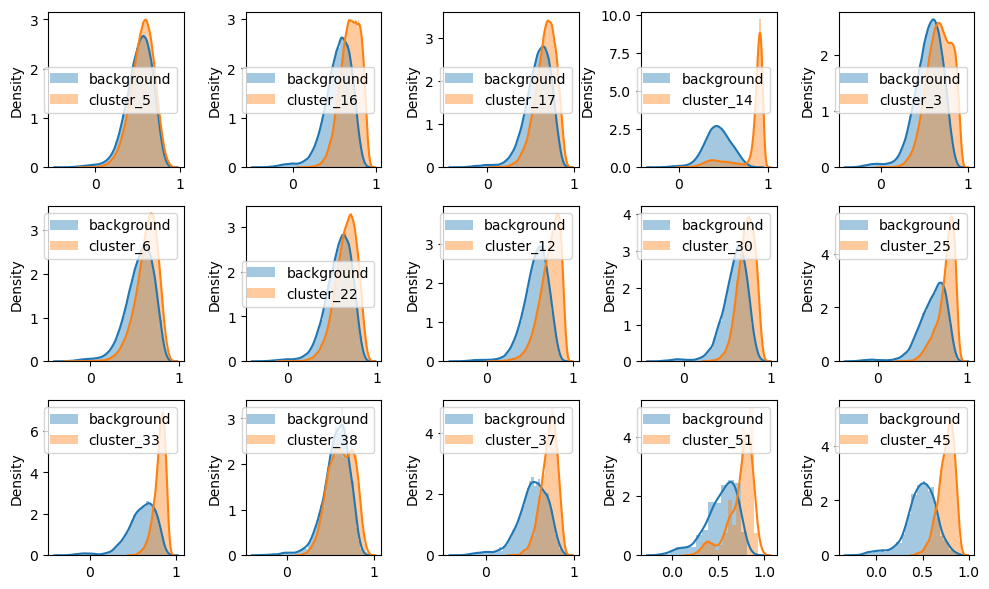

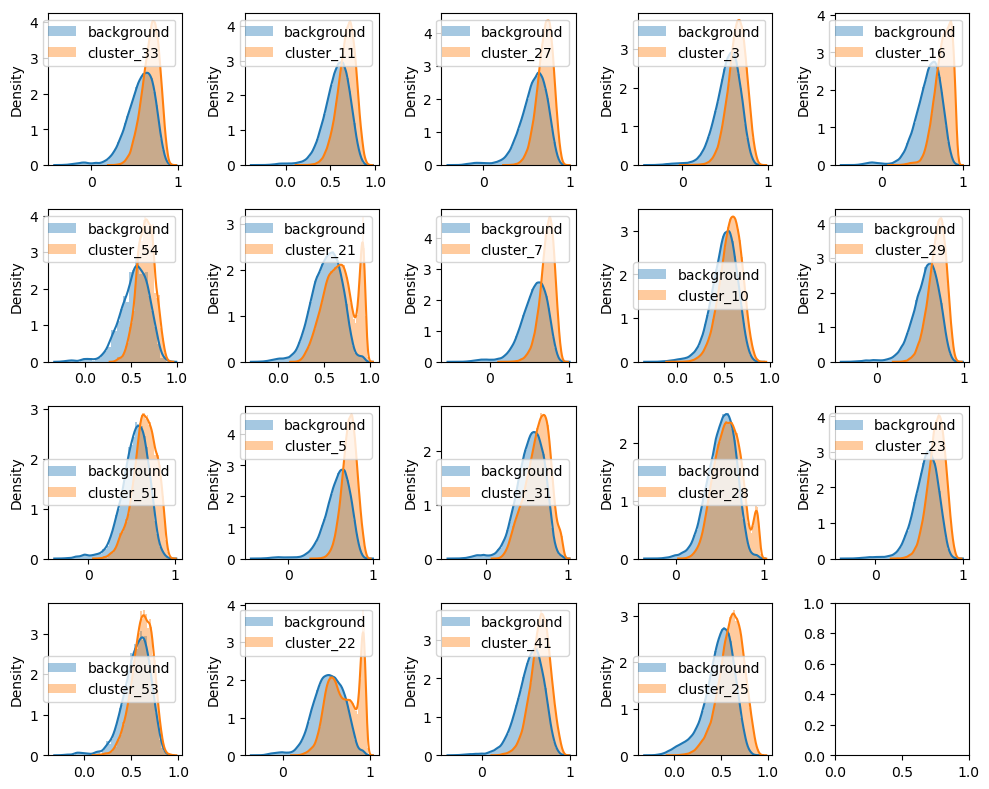

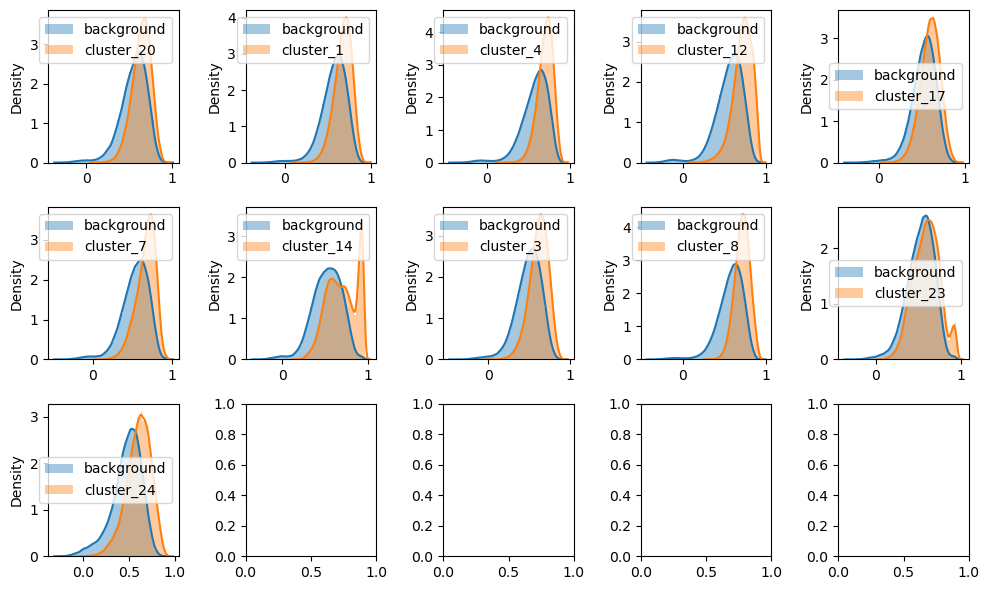

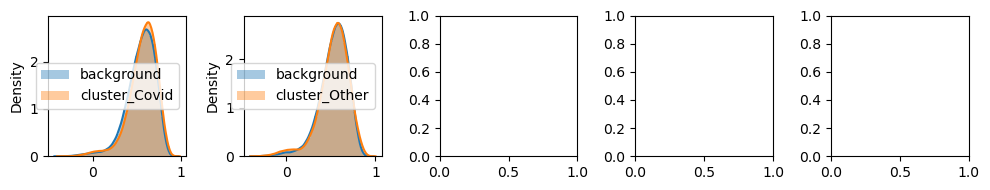

Clustering criteria Cluster  P-value  \
ifnpos_leiden_moe_cd8te5   ifnpos_leiden_moe_cd8te       5      0.0   
ifnpos_leiden_moe_cd8te16  ifnpos_leiden_moe_cd8te      16      0.0   
ifnpos_leiden_moe_cd8te17  ifnpos_leiden_moe_cd8te      17      0.0   
ifnpos_leiden_moe_cd8te14  ifnpos_leiden_moe_cd8te      14      0.0   
ifnpos_leiden_moe_cd8te3   ifnpos_leiden_moe_cd8te       3      0.0   

                              T-value  Mean cor  Background mean cor  
ifnpos_leiden_moe_cd8te5   192.000463  0.555039             0.516978  
ifnpos_leiden_moe_cd8te16  396.461319  0.692889             0.542790  
ifnpos_leiden_moe_cd8te17  241.502424  0.673365             0.580258  
ifnpos_leiden_moe_cd8te14  950.574067  0.820802             0.439115  
ifnpos_leiden_moe_cd8te3   649.870702  0.668219             0.543433

In [60]:
from scipy import stats
data_cd8te = data[data.obs.full_clustering == 'CD8.TE']
rs_squared = np.corrcoef(data_cd8te.obsm['X_pca'])
rs_squared = np.triu(rs_squared, k=1)
rs_squared[rs_squared==0] = -99
pvalues = pd.DataFrame({'Clustering criteria': [], 'Cluster': [], 'P-value': [], 'T-value': [], 'Mean cor': [], 'Background mean cor': []})

for cl_name in ['ifnpos_leiden_moe_cd8te','ifnpos_highres_leiden_rna_cd8te','ifnpos_lowres_leiden_rna_cd8te','specificity_ifnpos_cd8te']:
    
    react_leiden = data.obs[cl_name].unique().astype(str)[1:]
    n_cols = 5
    n_rows = int(np.ceil(len(react_leiden)/n_cols))
    fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(n_cols*2, n_rows*2))
    axes = axes.reshape(-1)
    
    
    for i, cluster in enumerate(react_leiden):
        mask_cluster = (data_cd8te.obs[cl_name] == cluster).values
        corr_cluster = rs_squared[mask_cluster][:, mask_cluster]
        corr_cluster = corr_cluster[corr_cluster!=-99]

        background = rs_squared[mask_cluster][:, np.invert(mask_cluster)]
        background = background[background!=-99]

        p = scipy.stats.ttest_ind(a=corr_cluster, b=background, equal_var=False, alternative='greater')
        pvalues.loc[cl_name+cluster,:] = [cl_name, cluster, p[1], p[0], np.mean(corr_cluster), np.mean(background)]
        
        background = np.random.choice(background, size=corr_cluster.shape[0], replace=False)
        sb.distplot(background, label='background', ax=axes[i])
        sb.distplot(corr_cluster, label=f'cluster_{cluster}', ax=axes[i])
        axes[i].legend()
        
    fig.tight_layout()
    plt.show()

pvalues.head(5)      

In [25]:
scipy.stats.ttest_ind(a=pvalues.loc[pvalues['Clustering criteria'] ==  'ifnpos_leiden_moe_cd8te','Mean cor'], 
                      b=pvalues.loc[pvalues['Clustering criteria'] ==  'ifnpos_highres_leiden_rna_cd8te','Mean cor'], 
                      equal_var=False, alternative='greater')

Ttest_indResult(statistic=1.7454388032058417, pvalue=0.047027608344921534)

In [26]:
scipy.stats.ttest_ind(a=pvalues.loc[pvalues['Clustering criteria'] ==  'ifnpos_leiden_moe_cd8te','Mean cor'], 
                      b=pvalues.loc[pvalues['Clustering criteria'] ==  'ifnpos_lowres_leiden_rna_cd8te','Mean cor'], 
                      equal_var=False, alternative='greater')

Ttest_indResult(statistic=1.959627218244927, pvalue=0.030895702854946767)

In [27]:
scipy.stats.ttest_ind(a=pvalues.loc[pvalues['Clustering criteria'] ==  'ifnpos_leiden_moe_cd8te','Mean cor'], 
                      b=pvalues.loc[pvalues['Clustering criteria'] ==  'specificity_ifnpos_cd8te','Mean cor'], 
                      equal_var=False, alternative='greater')

Ttest_indResult(statistic=6.196627745471893, pvalue=0.001177301894468557)

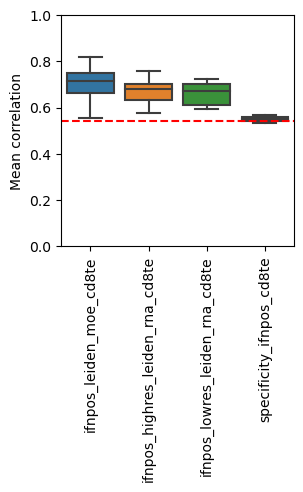

In [61]:
import seaborn as sns
rcParams['figure.figsize'] = (3, 3)
sns.boxplot(data=pvalues, x="Clustering criteria", y="Mean cor")
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel("Mean correlation")
plt.axis([-0.5, 3.5, 0, 1])
plt.plot([-0.5, 3.5], [pvalues['Background mean cor'].mean(), pvalues['Background mean cor'].mean()], color='red', linestyle='dashed')

### TCR distance

In [29]:
from tcrdist.repertoire import TCRrep
from tcrdist.tree import TCRtree

# TCRrep(cell_df = df,  organism = 'mouse', chains = ['alpha','beta'])

# You can access distance matrices:
#     tr.pw_alpha     - alpha chain pairwise distance matrix
#     tr.pw_beta      - alpha chain pairwise distance matrix
#     tr.pw_cdr3_a_aa - cdr3 alpha chain distance matrix
#     tr.pw_cdr3_b_aa - cdr3 beta chain distance matrix

In [30]:
clonotypes = data_cd8te.obs[['v_gene_alpha', 'IR_VJ_1_junction_aa', 'v_gene_beta', 'IR_VDJ_1_junction_aa', 'clonotype']].drop_duplicates(['IR_VJ_1_junction_aa', 'IR_VDJ_1_junction_aa']).reset_index(drop=True)
clonotypes = clonotypes.rename(columns={
    'v_gene_alpha': 'v_a_gene',
    'IR_VJ_1_junction_aa': 'cdr3_a_aa',
    'v_gene_beta': 'v_b_gene',
    'IR_VDJ_1_junction_aa':  'cdr3_b_aa'
})
clonotypes[clonotypes.columns[0:4]] = clonotypes[clonotypes.columns[0:4]].astype(str)
clonotypes[['v_a_gene','v_b_gene']] = clonotypes[['v_a_gene','v_b_gene']] + '*01'
clonotypes.head(3)

v_a_gene         cdr3_a_aa    v_b_gene           cdr3_b_aa  clonotype
0     TRAV8-4*01   CAVSVVRNNNARLMF  TRBV5-1*01  CASSARGASGERTDTQYF          0
1  TRAV29/DV5*01  CAASARGGGSNYKLTF  TRBV3-1*01     CASRPGTGDTGELFF         34
2      TRAV19*01     CALNSNSGYALNF  TRBV6-6*01     CASKVGSGGGNTIYF         37

In [31]:
# Compute distance between clonotypes
tr = TCRrep(cell_df=clonotypes, organism='human', chains=['alpha','beta'])
dists = tr.pw_cdr3_a_aa + tr.pw_cdr3_b_aa
dists = np.triu(dists, k=1) # mask lower triangular + diagonal entries
dists[dists==0] = -99
dists = pd.DataFrame(dists, columns=tr.clone_df['clonotype'], index=tr.clone_df['clonotype']) # pdDf to add index

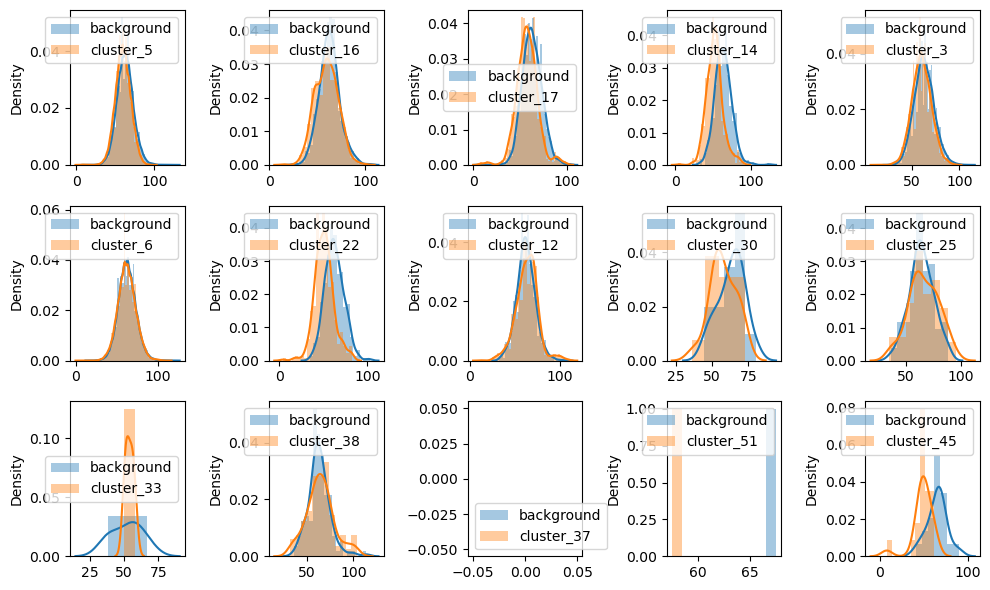

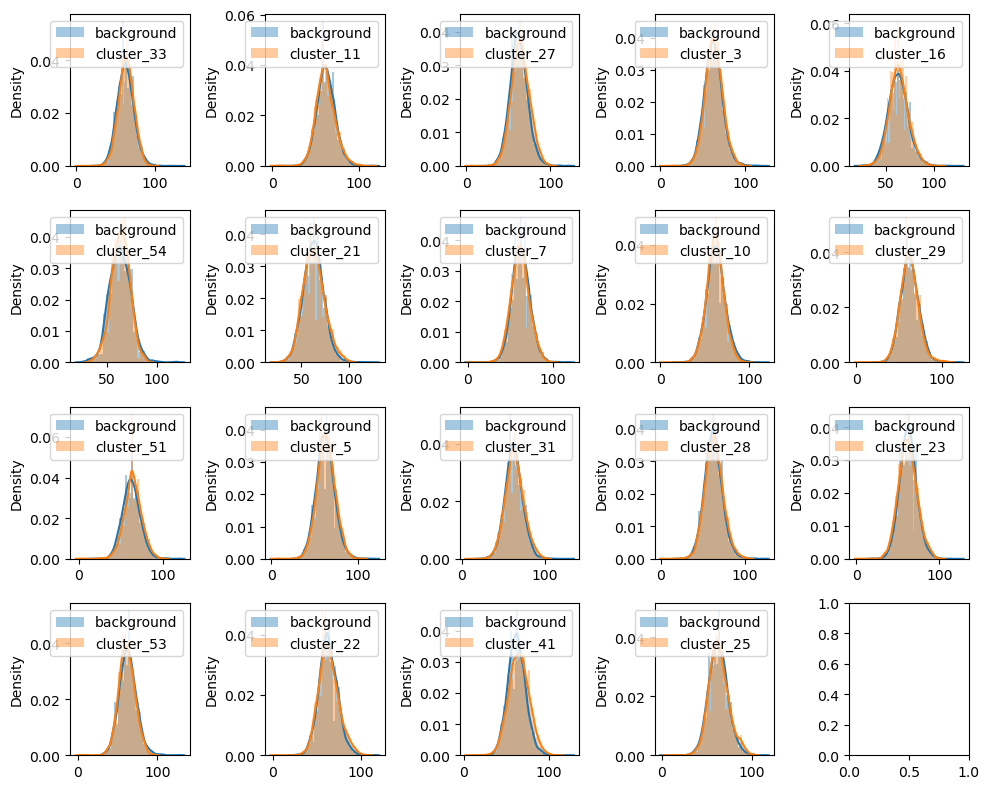

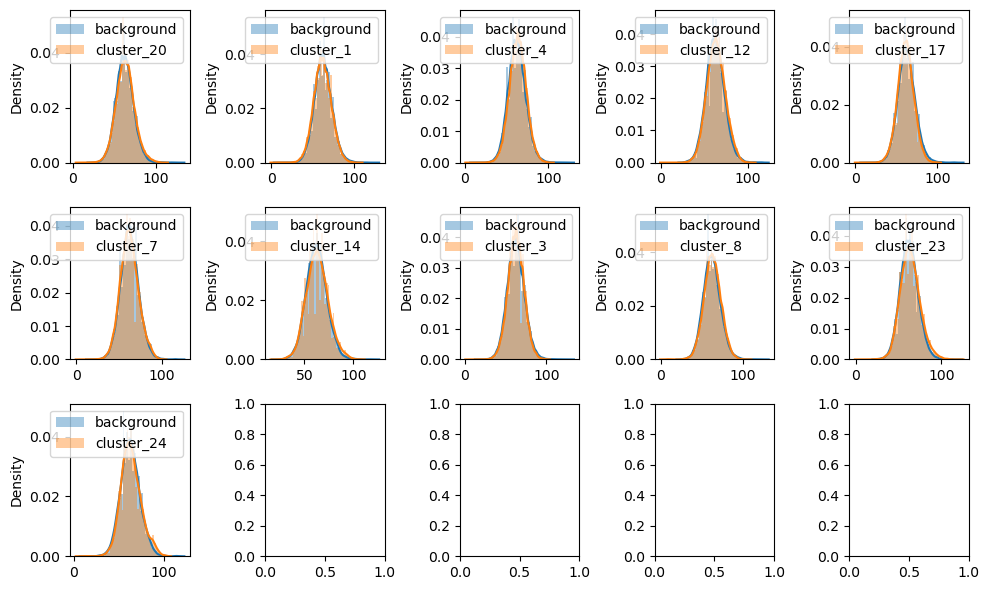

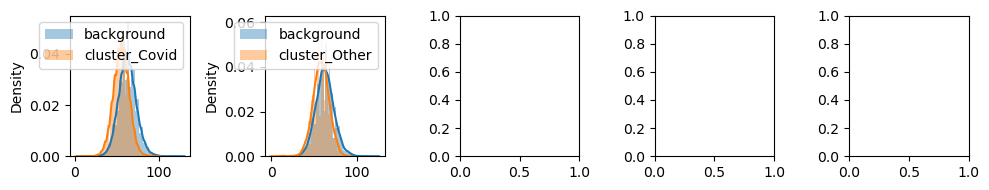

Clustering criteria Cluster        P-value  \
ifnpos_leiden_moe_cd8te5   ifnpos_leiden_moe_cd8te       5   0.000000e+00   
ifnpos_leiden_moe_cd8te16  ifnpos_leiden_moe_cd8te      16   2.649319e-11   
ifnpos_leiden_moe_cd8te17  ifnpos_leiden_moe_cd8te      17   1.614329e-88   
ifnpos_leiden_moe_cd8te14  ifnpos_leiden_moe_cd8te      14  8.455098e-101   
ifnpos_leiden_moe_cd8te3   ifnpos_leiden_moe_cd8te       3   3.064756e-98   

                             T-value  Mean distance  Background mean distance  
ifnpos_leiden_moe_cd8te5  -41.689549      59.823766                 62.551164  
ifnpos_leiden_moe_cd8te16  -6.666651      59.551920                 62.551164  
ifnpos_leiden_moe_cd8te17 -20.901950      57.313942                 62.551164  
ifnpos_leiden_moe_cd8te14 -25.487149      51.870871                 62.551164  
ifnpos_leiden_moe_cd8te3  -21.326482      59.976446                 62.551164

In [54]:
pvalues = pd.DataFrame({'Clustering criteria': [], 'Cluster': [], 'P-value': [], 'T-value': [], 'Mean distance': [], 'Background mean distance': []})

for cl_name in ['ifnpos_leiden_moe_cd8te','ifnpos_highres_leiden_rna_cd8te','ifnpos_lowres_leiden_rna_cd8te','specificity_ifnpos_cd8te']:
    
    react_leiden = data.obs[cl_name].unique().astype(str)[1:]
    n_cols = 5
    n_rows = int(np.ceil(len(react_leiden)/n_cols))
    fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(n_cols*2, n_rows*2))
    axes = axes.reshape(-1)
    
    
    for i, cluster in enumerate(react_leiden):
        clones = data[data.obs[cl_name]==cluster].obs['clonotype'].unique() 
        
        dist_cluster = dists.loc[clones,clones].values
        dist_cluster = dist_cluster[dist_cluster!=-99]
        
        dist_background = dists.values
        dist_background = dist_background[dist_background!=-99]

        p = scipy.stats.ttest_ind(a=dist_cluster, b=dist_background, equal_var=False, alternative='less')
        pvalues.loc[cl_name+cluster,:] = [cl_name, cluster, p[1], p[0], np.mean(dist_cluster), np.mean(dist_background)]
        
        dist_background = np.random.choice(dist_background, size=dist_cluster.shape[0], replace=False)
        sb.distplot(dist_background, label='background', ax=axes[i])
        sb.distplot(dist_cluster, label=f'cluster_{cluster}', ax=axes[i])
        axes[i].legend()
        
    fig.tight_layout()
    plt.show()

pvalues.head(5)   

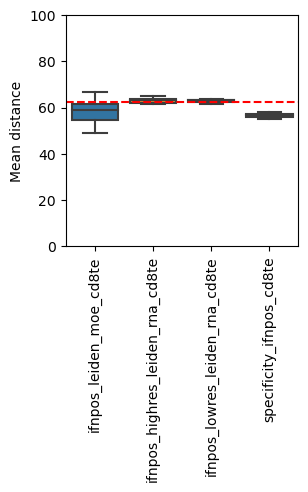

In [59]:
import seaborn as sns
rcParams['figure.figsize'] = (3, 3)
sns.boxplot(data=pvalues, x="Clustering criteria", y="Mean distance")
plt.xticks(rotation=90)
plt.xlabel("")
plt.axis([-0.5, 3.5, 0, 100])
plt.plot([-0.5, 3.5], [pvalues['Background mean distance'].mean(), pvalues['Background mean distance'].mean()], color='red', linestyle='dashed')

In [34]:
pvalues = pvalues[~pvalues['Mean distance'].isna()]
for cl in ['ifnpos_lowres_leiden_rna_cd8te','ifnpos_highres_leiden_rna_cd8te', 'specificity_ifnpos_cd8te']:
    
    pval = scipy.stats.ttest_ind(a=pvalues.loc[pvalues['Clustering criteria'] ==  'ifnpos_leiden_moe_cd8te','Mean distance'], 
                          b=pvalues.loc[pvalues['Clustering criteria'] ==  cl,'Mean distance'], 
                          equal_var=False)
    
    print(f'ifnpos_leiden_moe_cd8te vs {cl} - p value: {round(pval[1], 4)}, t value: {round(pval[0], 4)}')

ifnpos_leiden_moe_cd8te vs ifnpos_lowres_leiden_rna_cd8te - p value: 0.0053, t value: -3.3117
ifnpos_leiden_moe_cd8te vs ifnpos_highres_leiden_rna_cd8te - p value: 0.0042, t value: -3.4274
ifnpos_leiden_moe_cd8te vs specificity_ifnpos_cd8te - p value: 0.4653, t value: 0.8078


### IFNG levels

### Disease progression

After selecting clusters with highly significantly enriched IFN response scores (one-sided, unpaired t-test, p<0.001, Fig. 2d, Supplementary 201 Data 2), we observed that all 15 resulting clusters contained almost exclusively (>99.5%) cells from 202 donors with symptomatic SARS-CoV-2 infection withholding cells from asymptomatic infection or 203 healthy, and negative control groups (Fig. 2e). Overall, the selected clusters consisted of cells from 204 samples collected on average after 8.1± 4.0 days of symptom onset indicating an ongoing primary T cell response. Contrary, the cells of the remaining clusters originated from samples collected at a later date after symptom onset (11.8 ± 8.9 days).

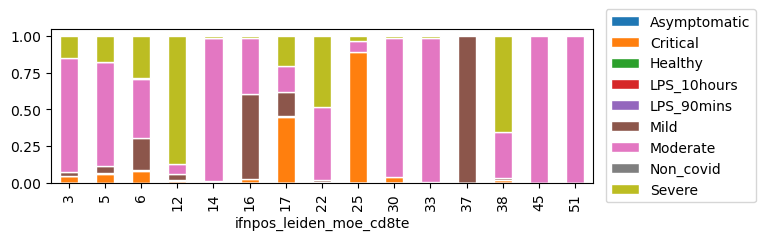

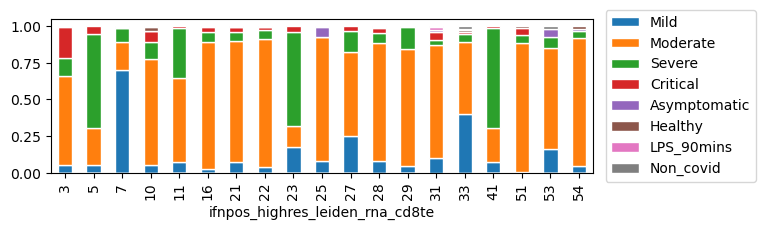

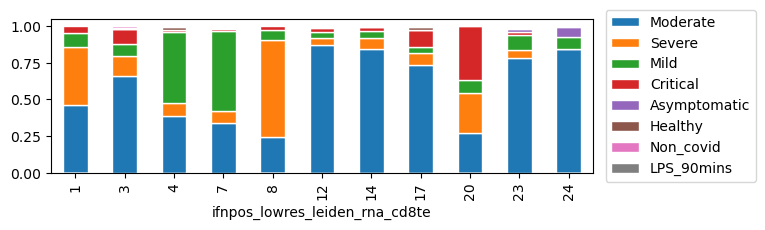

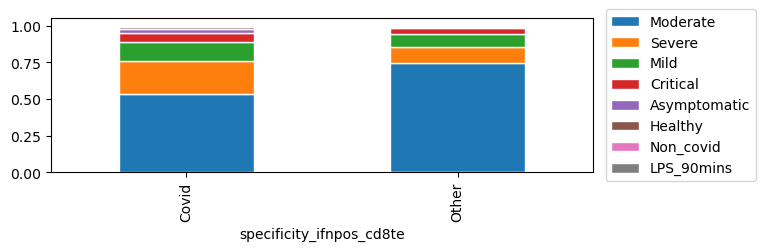

In [35]:
for cl_name in ['ifnpos_leiden_moe_cd8te','ifnpos_highres_leiden_rna_cd8te','ifnpos_lowres_leiden_rna_cd8te','specificity_ifnpos_cd8te']:
    disease_ct = data.obs[[cl_name,'Status_on_day_collection_summary']].value_counts().reset_index()
    disease_ct = pd.pivot(disease_ct, index=cl_name, columns='Status_on_day_collection_summary', values=0).fillna(0)
    disease_ct = disease_ct.div(disease_ct.sum(axis=1), axis=0)

    rcParams['figure.figsize'] = (7, 2)
    disease_ct.plot(kind='bar', stacked=True, edgecolor='white')
    plt.legend(bbox_to_anchor=(1.3, 0.5), loc='right', borderaxespad=0)

In [ ]:
for cl_name in ['ifnpos_leiden_moe_cd8te','ifnpos_highres_leiden_rna_cd8te','ifnpos_lowres_leiden_rna_cd8te','specificity_ifnpos_cd8te']:
    disease_ct = data.obs[[cl_name,'Status_on_day_collection_summary']].value_counts().reset_index()
    sns.violinplot(data=data.obs, x="Clustering criteria", y="Mean distance")

### Heatmap of cluster overlap

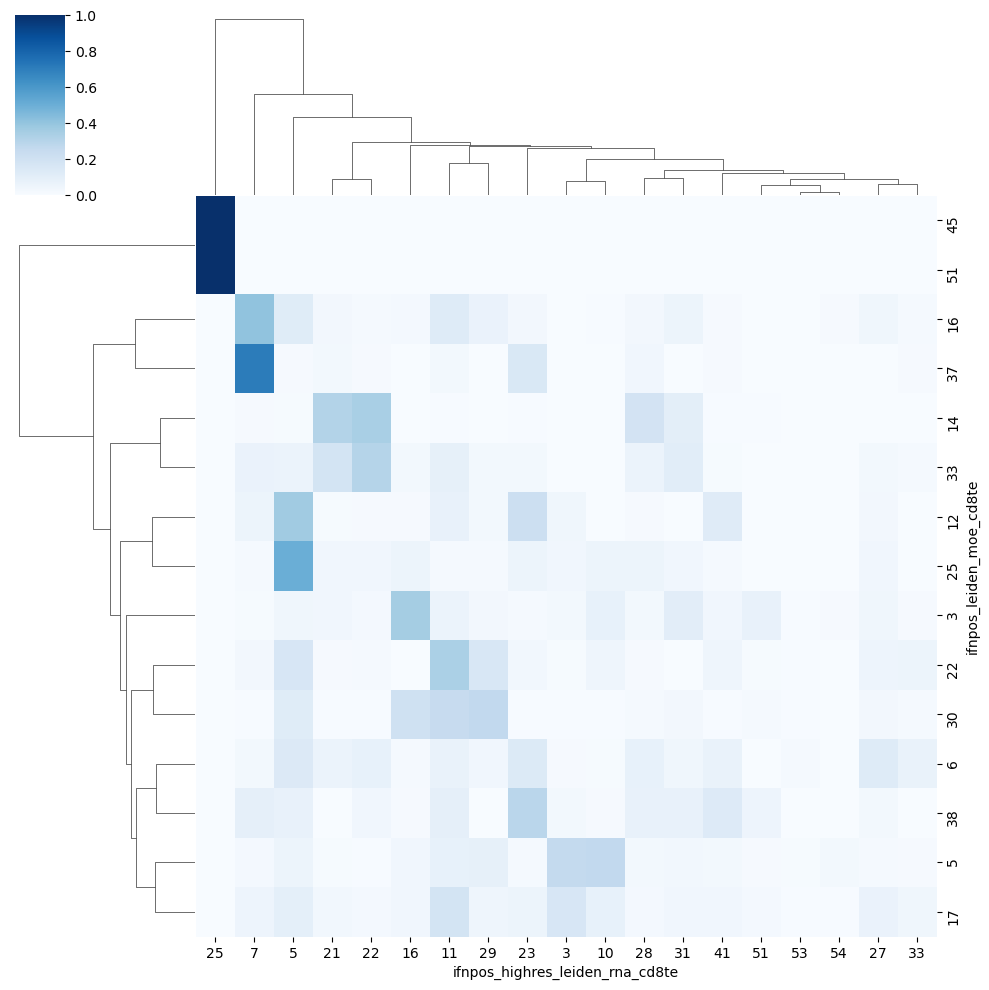

In [66]:
contingency = data.obs[['ifnpos_leiden_moe_cd8te','ifnpos_highres_leiden_rna_cd8te']].value_counts().reset_index().pivot(index='ifnpos_leiden_moe_cd8te', columns='ifnpos_highres_leiden_rna_cd8te',values=0)
contingency[contingency.isna()] = 0
contingency = contingency.div(contingency.sum(axis=1), axis=0) 
sns.clustermap(contingency, cmap='Blues')
plt.show()

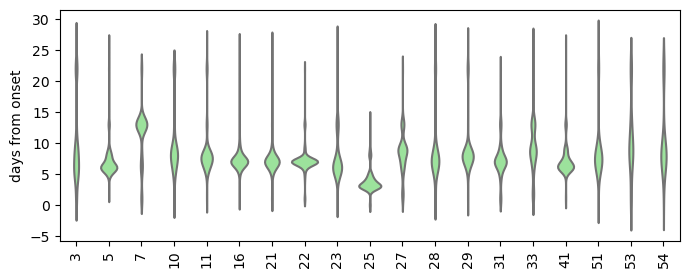

In [192]:
rcParams['figure.figsize'] = (8, 3)

dt = data.obs[['days_from_onset_numeric','ifnpos_highres_leiden_rna_cd8te']].copy()
dt = dt.loc[dt.isna().sum(axis=1)==0, :]

sns.violinplot(data=dt, x="ifnpos_highres_leiden_rna_cd8te", y="days_from_onset_numeric", inner=None, color='lightgreen')
plt.xticks(rotation=90)    
plt.xlabel("")
plt.ylabel('days from onset')
plt.show()

In [ ]:
data.obs[['ifnpos_leiden_moe_cd8te','ifnpos_lowres_leiden_rna_cd8te']]

In [ ]:
nmi = metrics.normalized_mutual_info_score(dt.loc[non_na, label], dt.loc[non_na, cl_name])
rand = metrics.adjusted_rand_score(dt.loc[non_na, label], dt.loc[non_na, cl_name])

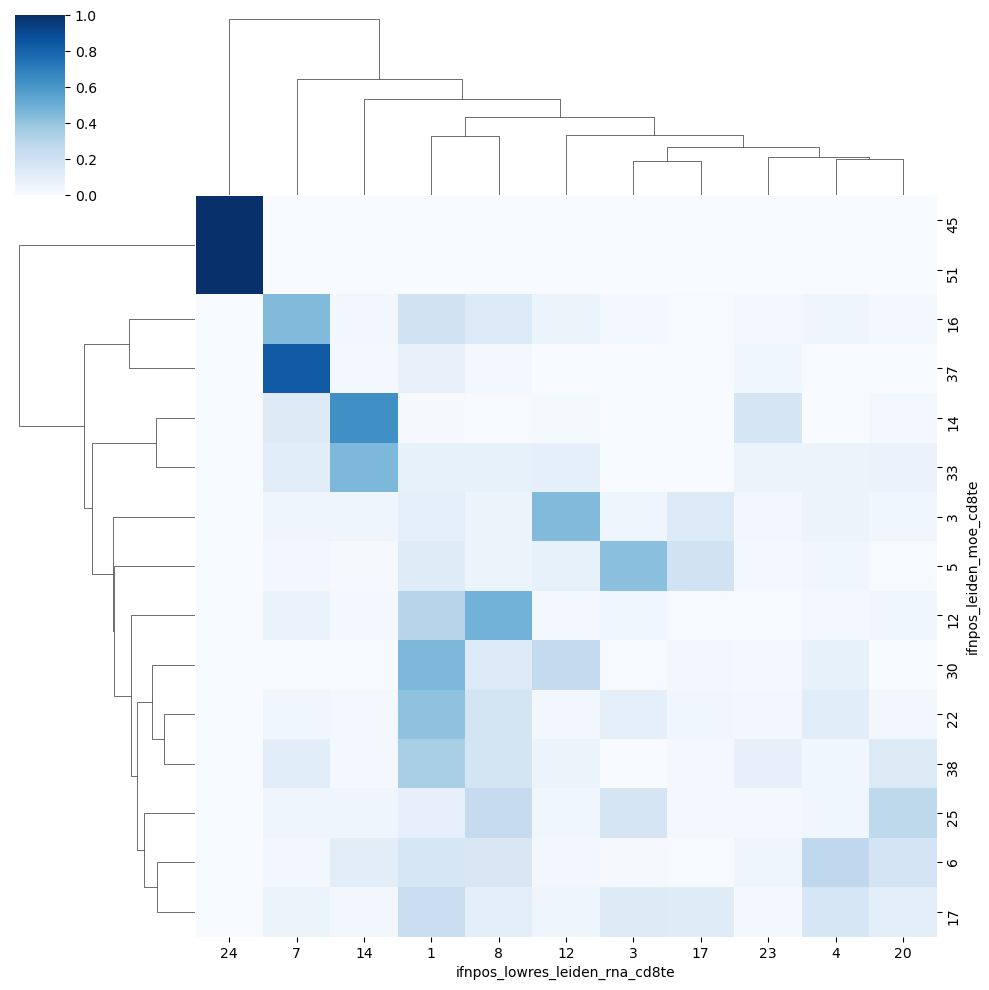

In [67]:
contingency = data.obs[['ifnpos_leiden_moe_cd8te','ifnpos_lowres_leiden_rna_cd8te']].value_counts().reset_index().pivot(index='ifnpos_leiden_moe_cd8te', columns='ifnpos_lowres_leiden_rna_cd8te',values=0)
contingency[contingency.isna()] = 0
contingency = contingency.div(contingency.sum(axis=1), axis=0) 
sns.clustermap(contingency, cmap='Blues')
plt.show()